___

### Car classifier

In [ ]:
# imports


#import json
#import tensorflow
#import concurrent.futures
#from datasets import load_dataset
#from resnet import ResNet152, ResNet50


from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch_directml as dml
import torch.optim as optim
import math
import copy
import os
import cv2
import pickle
import gc
import time
import re
import shutil
import random
import psutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def analyze_image_filenames(image_dir, sample_size=500):
    """Analyze image filename patterns to understand their structure"""
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print("No image files found in directory!")
        return []

    sample = random.sample(image_files, min(sample_size, len(image_files)))
    
    print(f"\nAnalyzing {len(sample)} sample image filenames:")
    for filename in sample:
        print(f"  - {filename}")
    
    # Try to identify patterns
    separators = ['_', '-', ' ']
    for sep in separators:
        has_separator = any(sep in filename for filename in sample)
        if has_separator:
            print(f"\nFound separator '{sep}' in filenames")
            parts_counts = [len(f.split(sep)) for f in sample if sep in f]
            if parts_counts:
                print(f"  Average parts when split by '{sep}': {sum(parts_counts)/len(parts_counts):.1f}")
    
    return image_files

# Run the analysis
image_files = analyze_image_filenames("./images/cars2")


Analyzing 500 sample image filenames:
  - Toyota_Camry_2014_22_16_170_25_4_71_57_189_25_FWD_5_4_4dr_fXy.jpg
  - Ford_Fiesta_2011_13_15_120_16_4_67_58_173_28_FWD_5_4_4dr_mUU.jpg
  - MG car_MG car_15.jpg
  - Kia_Rio_2015_16_15_130_16_4_67_57_171_27_FWD_5_4_4dr_LyK.jpg
  - Nissan_Murano_2015_40_20_260_35_6_75_66_192_21_AWD_5_4_SUV_AGm.jpg
  - Buick_Cascada_2019_33_20_200_16_4_72_56_184_21_FWD_4_2_Convertible_RHH.jpg
  - BMW_4-Series_2017_50_18_240_20_4_71_54_182_23_RWD_4_2_Convertible_Okh.jpg
  - Rolls-Royce_Ghost_2017_339_19_560_66_12_76_61_219_12_RWD_5_4_4dr_bVe.jpg
  - Ford_Flex_2011_40_19_260_35_6_75_68_201_16_AWD_7_4_SUV_fQC.jpg
  - MINI_Cooper_2017_25_15_130_15_3_68_55_151_28_FWD_4_2_Convertible_fij.jpg
  - Nissan_Rogue Sport_2019_23_16_140_20_4_72_63_172_24_AWD_5_4_SUV_fHA.jpg
  - Hummer car back_Hummer_car_back_32.jpg
  - Land Rover_Range Rover Velar_2019_56_19_180_20_4_76_65_188_26_4WD_5_4_SUV_AeK.jpg
  - BMW Alpina car_BMW_Alpina_car_49.jpg
  - Kia_Niro_2017_25_16_130_16_4_71_6

In [ ]:
# Load combined_cars.csv
csv_path = './processed_data/combined_cars.csv'
combined_cars_df = pd.read_csv(csv_path)

# Create class labels from Make and Model
combined_cars_df['Class'] = combined_cars_df['Make'] # + ' ' + combined_cars_df['Model']
class_names = combined_cars_df['Class'].unique().tolist()
class_names.append('other')  # Add 'other' for non-car images
print(f"Class names: {class_names}")
len(class_names)


Class names: ['Chevrolet', 'Ford', 'Hyundai', 'Volkswagen', 'Honda', 'Maruti', 'BMW', 'Mahindra', 'Tata', 'Fiat', 'Cars Movie', 'Toyota', 'Nissan', 'Volvo', 'Ambassador', 'Skoda', 'Audi', 'Datsun', 'Renault', 'OpelCorsa', 'Kia', 'Mercedes-Benz', 'Mitsubishi', 'MG', 'Land', 'Jeep', 'Jaguar', 'Isuzu', 'Force', 'Daewoo', 'Lexus', 'Infiniti', 'Land Rover', 'Lincoln', 'Lotus', 'Chrysler', 'Maserati', 'Cadillac', 'Rolls-Royce', 'Oldsmobile', 'GMC', 'Alfa Romeo', 'Buick', 'Mercury', 'Dodge', 'Laforza Automobile Inc', 'Suzuki', 'Mazda', 'Porsche', 'Aston Martin', 'Acura', 'MINI', 'Rivian', 'Pontiac', 'Spyker', 'Tecstar, LP', 'Bentley', 'Saturn', 'Dacia', 'Lamborghini', 'Roush Performance', 'Tesla', 'CX Automotive', 'Subaru', 'Lucid', 'Ferrari', 'Vinfast', 'Genesis', 'Koenigsegg', 'McLaren Automotive', 'Plymouth', 'Federal Coach', 'Vector', 'Geo', 'Kenyon Corporation Of America', 'Scion', 'smart', 'Ram', 'Bugatti', 'Wallace Environmental', 'J.K. Motors', 'Maybach', 'Volga Associated Automobile'

158

Using top 157 makes as classes


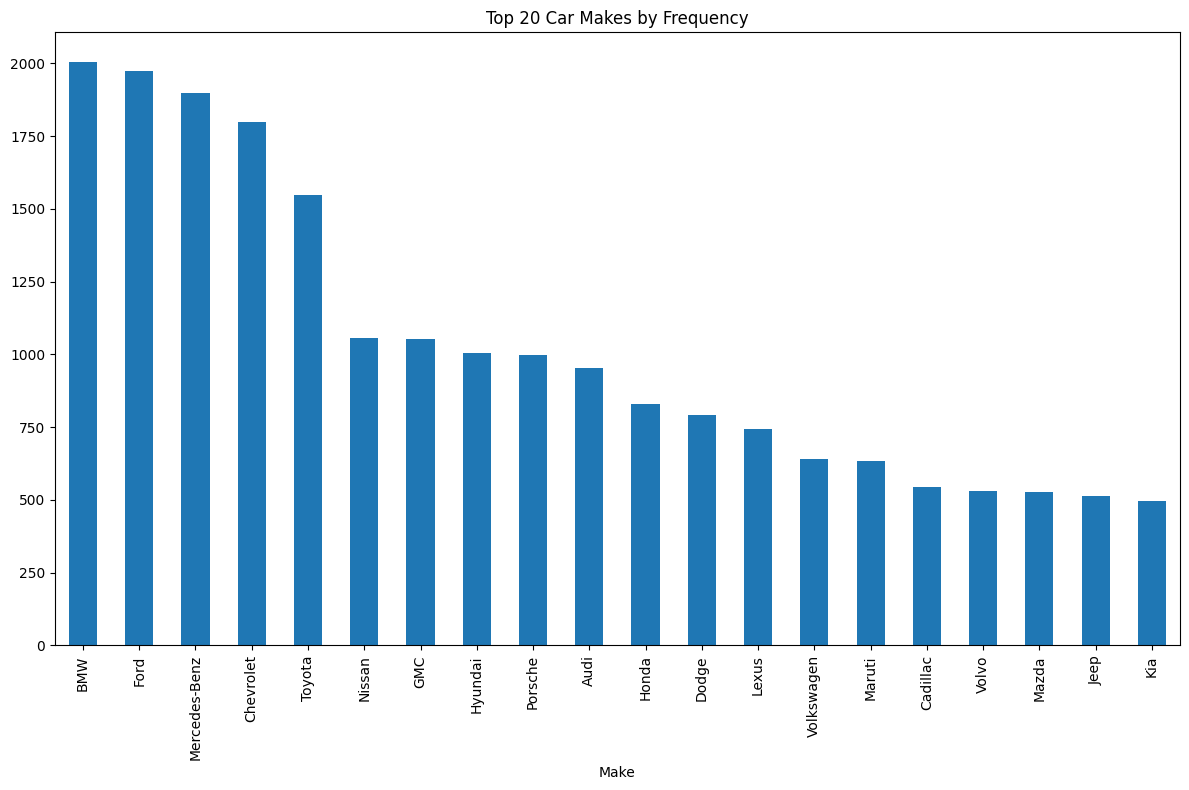

In [5]:
# Count frequency of each make to identify the most common ones
make_counts = combined_cars_df['Make'].value_counts()

# Plot distribution of makes
plt.figure(figsize=(12, 8))
make_counts.head(20).plot(kind='bar')
plt.title('Top 20 Car Makes by Frequency')
plt.tight_layout()

# Select top N makes to keep number of classes manageable
N = 159  # Your target number of classes
top_makes = make_counts.head(N).index.tolist()
print(f"Using top {len(top_makes)} makes as classes")

In [19]:
# Preparation of the images & datasets


def process_image(args):
    i, img_file, source_dir, output_dir, top_makes, train_end, valid_end = args
    try:
        # Determine split
        if i < train_end:
            split = 'train'
        elif i < valid_end:
            split = 'valid'
        else:
            split = 'test'

        # Source path
        src_path = os.path.join(source_dir, img_file)
        
        # Determine class label based on filename
        img_file_lower = img_file.lower()
        img_class = 'other'  # Default class
        
        for make in top_makes:
            # Simple string matching
            if make.lower() in img_file_lower:
                img_class = make
                break
        
        # Replace spaces with underscores for directory names
        class_dir_name = img_class.replace(' ', '_')
        
        # Destination directory
        dst_dir = os.path.join(output_dir, split, class_dir_name)
        
        # Resize and save the image
        img = cv2.imread(src_path)
        if img is None:
            return f"Warning: Could not read image {src_path}"
            
        # Use INTER_AREA for downsampling
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        dst_path = os.path.join(dst_dir, img_file)
        cv2.imwrite(dst_path, img_resized)
        
        return None  # No error
        
    except Exception as e:
        return f"Error processing {img_file}: {str(e)}"


def prepare_dataset_sequential(source_dir, output_dir='./data', top_makes=None, 
                           sample_size=77528, train_split=0.7, valid_split=0.15):
    """
    Prepare a dataset with class labels based on top car makes (sequential version).
    """

    # Create output directories
    for split_dir in [os.path.join(output_dir, split) for split in ['train', 'valid', 'test']]:
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)
        os.makedirs(split_dir, exist_ok=True)
    
    # Get all images
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    # Limit to sample size
    image_files = image_files[:sample_size]
    print(f"Using {len(image_files)} images (from total {len(os.listdir(source_dir))})")

    # Calculate split indices
    train_end = int(len(image_files) * train_split)
    valid_end = train_end + int(len(image_files) * valid_split)
    
    # Track which classes have been found in images
    found_classes = set()
    
    # First pass: identify which classes are actually present in the dataset
    print("Scanning images to identify classes...")
    for img_file in tqdm(image_files, desc="Identifying classes"):
        img_file_lower = img_file.lower()
        for make in top_makes:
            if make.lower() in img_file_lower:
                found_classes.add(make)
                break
    
    # Add 'other' class if needed
    found_classes.add('other')  # Always include 'other' class
    
    print(f"Found {len(found_classes)} classes in the dataset")
    
    # Create only directories for classes that exist
    for split in ['train', 'valid', 'test']:
        for make in found_classes:
            safe_make = make.replace(' ', '_')
            os.makedirs(os.path.join(output_dir, split, safe_make), exist_ok=True)
    
    # Process images sequentially with tqdm progress bar
    errors = []
    class_distribution = {make: 0 for make in found_classes}
    
    for i, img_file in tqdm(enumerate(image_files), total=len(image_files), desc="Processing images"):
        try:
            # Determine split
            if i < train_end:
                split = 'train'
            elif i < valid_end:
                split = 'valid'
            else:
                split = 'test'

            # Source path
            src_path = os.path.join(source_dir, img_file)
            
            # Determine class label based on filename
            img_file_lower = img_file.lower()
            img_class = 'other'  # Default class
            
            for make in found_classes:
                if make != 'other' and make.lower() in img_file_lower:
                    img_class = make
                    break
            
            # Replace spaces with underscores for directory names
            class_dir_name = img_class.replace(' ', '_')
            
            # Destination directory
            dst_dir = os.path.join(output_dir, split, class_dir_name)
            
            # Resize and save the image
            img = cv2.imread(src_path)
            if img is None:
                errors.append(f"Warning: Could not read image {src_path}")
                continue
                
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            dst_path = os.path.join(dst_dir, img_file)
            cv2.imwrite(dst_path, img_resized)
            
            # Update class distribution counter
            class_distribution[img_class] += 1
            
        except Exception as e:
            errors.append(f"Error processing {img_file}: {str(e)}")
    
    # Print errors if any
    if errors:
        print("\nErrors encountered:")
        for error in errors:
            print(error)
    
    # Print class distribution
    print("\nClass distribution:")
    for make, count in sorted(class_distribution.items(), key=lambda x: x[1], reverse=True):
        print(f"{make}: {count} images")
    
    # Check for empty classes again (shouldn't happen with our new approach)
    empty_classes = [make for make, count in class_distribution.items() if count == 0]
    if empty_classes:
        print(f"\nWarning: {len(empty_classes)} empty classes detected.")
        print(f"Empty classes: {empty_classes}")
        
        # Remove empty class directories to prevent errors
        for split in ['train', 'valid', 'test']:
            for empty_class in empty_classes:
                empty_dir = os.path.join(output_dir, split, empty_class.replace(' ', '_'))
                if os.path.exists(empty_dir):
                    shutil.rmtree(empty_dir)
                    print(f"Removed empty directory: {empty_dir}")

    print("\nDataset preparation complete.")
    
    # Return only class names that have images
    return [make.replace(' ', '_') for make in found_classes if class_distribution[make] > 0]


def filter_out_other_class(base_dir):
    """
    Remove the 'other' class folder from all dataset splits
    """
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(base_dir, split, 'other')
        if os.path.exists(other_dir):
            print(f"Removing 'other' class from {split} split")
            shutil.rmtree(other_dir)
            print(f"Removed: {other_dir}")
        else:
            print(f"No 'other' class found in {split} split")
    
    print("Removed 'other' class from all dataset splits")
    
    
# Modified dataset loading code with error handling
def create_image_datasets(base_dir, data_transforms):
    """Create image datasets with error handling for empty class directories"""
    datasets_dict = {}
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Get list of non-empty class directories
        valid_classes = []
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                # Check if directory has at least one valid image
                valid_files = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if valid_files:
                    valid_classes.append(class_name)
                else:
                    # Remove empty directory to avoid future errors
                    print(f"Removing empty class directory: {class_dir}")
                    shutil.rmtree(class_dir)
        
        print(f"Found {len(valid_classes)} valid classes in {split} split")
        
        # Create dataset with only valid classes
        try:
            datasets_dict[split] = datasets.ImageFolder(split_dir, transform=data_transforms[split])
        except Exception as e:
            print(f"Error loading {split} dataset: {str(e)}")
            # Create empty dataset as fallback
            datasets_dict[split] = None
    
    return datasets_dict


In [3]:
# Unfreezing layers

# Resnet layers
def unfreeze_layers(model, num_blocks):
    """Unfreeze blocks of ResNet model starting from the end"""
    # First freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    trainable_layers = []
    
    # Always unfreeze fully connected layer (classifier)
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
        trainable_layers.append(f"fc.{name}")
    
    # Define blocks to unfreeze in order (from last to first)
    if num_blocks > 0:
        blocks_to_unfreeze = []
        
        # Add layer4 (last block)
        if num_blocks >= 1:
            blocks_to_unfreeze.append('layer4')
        
        # Add layer3
        if num_blocks >= 2:
            blocks_to_unfreeze.append('layer3')
        
        # Add layer2
        if num_blocks >= 3:
            blocks_to_unfreeze.append('layer2')
        
        # Add layer1
        if num_blocks >= 4:
            blocks_to_unfreeze.append('layer1')
        
        # Unfreeze the selected blocks
        for block_name in blocks_to_unfreeze:
            block = getattr(model, block_name)
            for name, param in block.named_parameters():
                param.requires_grad = True
                trainable_layers.append(f"{block_name}.{name}")
    
    print(f"Unfrozen {len(trainable_layers)} layers in total")
    return trainable_layers



# Efficientnet layers
def unfreeze_efficientnet_layers(model, num_blocks):
    """Unfreeze blocks of EfficientNet model starting from the end"""
    # First freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    trainable_layers = []
    
    # Always unfreeze classifier layer
    for name, param in model.classifier.named_parameters():
        param.requires_grad = True
        trainable_layers.append(f"classifier.{name}")
    
    # Define blocks to unfreeze in order (from last to first)
    if num_blocks > 0:
        # EfficientNet has blocks indexed from 0 to N-1
        total_blocks = len(model.blocks)
        
        # Calculate how many blocks to unfreeze from the end
        blocks_to_unfreeze = min(num_blocks, total_blocks)
        
        # Unfreeze blocks from the end
        for i in range(blocks_to_unfreeze):
            block_idx = total_blocks - 1 - i
            if block_idx >= 0:
                for name, param in model.blocks[block_idx].named_parameters():
                    param.requires_grad = True
                    trainable_layers.append(f"blocks.{block_idx}.{name}")
    
    print(f"Unfrozen {len(trainable_layers)} layers in total")
    return trainable_layers

In [4]:
# GPU & Memory-related functions


def check_gpu_utilization():
    """Monitor GPU usage the best we can with DirectML"""
    try:
        print("\nGPU Metrics:")
        # Get process memory info as a proxy
        process = psutil.Process(os.getpid())
        print(f"Process memory usage: {process.memory_info().rss / 1024**2:.2f} MB")
        print("Note: DirectML doesn't expose detailed GPU metrics")
    except Exception as e:
        print(f"Error getting metrics: {str(e)}")
       
        
def aggressive_memory_cleanup():
    """Aggressively clean up memory"""
    import gc
    
    # Force garbage collection
    gc.collect()
    
    # Clear DirectML cache if possible
    if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
        torch.directml.empty_cache()
        print("Cleared DirectML cache")


def memory_efficient_forward(model, inputs, max_retries=3):
    """Better OOM handling for forward pass"""
    batch_size = inputs.shape[0]
    
    # First try: normal forward pass with full batch
    try:
        return model(inputs)
    except RuntimeError as e:
        # If OOM, try to split the batch
        if "out of memory" in str(e) or "not enough GPU" in str(e):
            print(f"OOM with batch size {batch_size}, trying to split batch...")
            
            # Clear cache immediately
            if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                torch.directml.empty_cache()
            
            # If batch size is already 1, we can't reduce further
            if batch_size <= 1:
                print("Cannot split batch further, minimum batch size reached")
                raise e
                
            # Try with half the batch size
            half = batch_size // 2
            try:
                # Process first half
                out1 = model(inputs[:half])
                # Process second half
                out2 = model(inputs[half:])
                
                # Combine results (assuming the model output has logits)
                if hasattr(out1, 'logits'):
                    combined_logits = torch.cat([out1.logits, out2.logits], dim=0)
                    # Create a new output object with combined logits
                    from transformers.modeling_outputs import ImageClassifierOutput
                    return ImageClassifierOutput(logits=combined_logits)
                else:
                    # For plain tensors
                    return torch.cat([out1, out2], dim=0)
            except RuntimeError:
                print("Still OOM after splitting batch. Please reduce batch size further.")
                raise
        else:
            # Not an OOM error
            raise e



In [5]:
# Training functions for the ResNet Model


# Configure DirectML
dml_device = dml.device(dml.default_device())
print(f"Using DirectML device: {dml.device_name(dml.default_device())}")

# Define paths
#source_dir = './images/cars'  # Source directory containing all images
source_dir = './images/cars2'
data_dir = './data'  # Output directory for train, valid, and test splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Initialize "variable" connection with the GPU
device = dml_device

torch.backends.cudnn.benchmark = True  # Speed up training



Using DirectML device: AMD  Radeon RX 7800 XT 


In [ ]:
# Prepare the class_names
# Use the function
class_names = prepare_dataset_sequential(
    source_dir='./images/cars2',
    output_dir='./data',
    top_makes=top_makes,
    sample_size=77528 # Adjust based on your available images
)

In [6]:
# Training functions regarding the model



def pseudo_label_other_images(model, data_dir, class_names, device, transforms, confidence_threshold=0.5, max_samples=3000):
    """
    Generate pseudo-labels for images in the 'other' class with more aggressive parameters.
    
    Args:
        model: Trained model to use for predictions
        data_dir: Base data directory
        class_names: List of class names
        device: Device to run model on
        transforms: Image transformations to apply
        confidence_threshold: Threshold to consider a prediction valid (lower = more aggressive)
        max_samples: Maximum number of samples to process from 'other' class (higher = more aggressive)
    """
    print("\nGenerating pseudo-labels for 'other' class images...")
    model.eval()
    
    moved_images = {split: 0 for split in ['train', 'valid', 'test']}
    total_other_images = {split: 0 for split in ['train', 'valid', 'test']}
    
    # Find 'other' class index to avoid labeling as 'other'
    other_idx = -1
    for i, cls in enumerate(class_names):
        if cls == 'other':
            other_idx = i
            break
    
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(data_dir, split, 'other')
        if not os.path.exists(other_dir):
            continue
            
        other_images = [f for f in os.listdir(other_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_other_images[split] = len(other_images)
        
        if not other_images:
            continue
        
        # Process more images than before - more aggressive sampling
        if split == 'train' and len(other_images) > max_samples:
            sample_size = min(max_samples, len(other_images))
            other_images = random.sample(other_images, sample_size)
            print(f"Processing {sample_size} sampled images from {split}/other (from total {total_other_images[split]})")
        else:
            print(f"Processing {len(other_images)} images from {split}/other")
        
        # Process each image
        for img_file in tqdm(other_images, desc=f"Pseudo-labeling {split}/other"):
            img_path = os.path.join(other_dir, img_file)
            
            # Load and preprocess the image
            try:
                image = Image.open(img_path).convert('RGB')
                img_tensor = transforms(image).unsqueeze(0).to(device)
                
                # Get model prediction
                with torch.no_grad():
                    outputs = model(img_tensor)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)[0]
                    
                    # Mask out 'other' class to prevent it from being the top prediction
                    if other_idx >= 0:
                        probs[other_idx] = 0.0
                    
                    conf_val, pred_idx = torch.max(probs, 0)
                    confidence = conf_val.item()
                    pred_class = class_names[pred_idx.item()]
                
                # More aggressive threshold and explicit exclusion of 'other' class
                if confidence >= confidence_threshold and pred_class != 'other':
                    target_dir = os.path.join(data_dir, split, pred_class)
                    os.makedirs(target_dir, exist_ok=True)
                    target_path = os.path.join(target_dir, img_file)
                    
                    # Move the file
                    shutil.move(img_path, target_path)
                    moved_images[split] += 1
            
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    # Print summary
    print("\nPseudo-labeling summary:")
    for split in ['train', 'valid', 'test']:
        if total_other_images[split] > 0:
            percent = (moved_images[split] / total_other_images[split]) * 100
            print(f"{split}: Moved {moved_images[split]} of {total_other_images[split]} images ({percent:.1f}%)")
    
    return moved_images



def train_with_progressive_unfreezing(num_epochs=150, accumulation_steps=2):
    """
    Train the model with progressive unfreezing, focused only on known car classes.
    """
    global dataloaders, model, criterion, optimizer, scheduler, class_names, class_weights_tensor, learning_rate, batch_size
    
    # Create checkpoint directory
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Check for previous checkpoint to resume from
    interrupt_checkpoint_path = os.path.join(checkpoint_dir, 'interrupt_checkpoint.pth')
    start_epoch = 0
    start_time = time.time()
    best_acc = 0.0
    current_stage = 0
    
    
    # if os.path.exists(interrupt_checkpoint_path):
    #     print(f"\nFound training checkpoint at {interrupt_checkpoint_path}, resuming...")
    #     try:
    #         checkpoint = torch.load(interrupt_checkpoint_path)
    #         start_epoch = checkpoint['epoch'] + 1
    #         best_acc = checkpoint['best_acc']
    #         current_stage = checkpoint.get('stage', 0)
    #         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #         scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    #         print(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.4f} (stage {current_stage+1})")
    #     except Exception as e:
    #         print(f"Error loading training state: {e}")
    #         print("Starting from scratch instead")
            
    has_checkpoint = False
    if os.path.exists(interrupt_checkpoint_path):
        print(f"\nFound training checkpoint at {interrupt_checkpoint_path}, resuming...")
        try:
            checkpoint = torch.load(interrupt_checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            best_acc = checkpoint['best_acc']
            current_stage = checkpoint.get('stage', 0)
            # Don't load optimizer/scheduler yet!
            print(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.4f} (stage {current_stage+1})")
            has_checkpoint = True
        except Exception as e:
            print(f"Error loading training state: {e}")
            print("Starting from scratch instead")
    
    # Set up training stages with progressive unfreezing
    # Feel free to add or delete a stage depending on how many epochs you are using
    # stages = [
    #     {'epochs': num_epochs // 4, 'unfreeze': 1},   
    #     {'epochs': num_epochs // 4, 'unfreeze': 2},  
    #     {'epochs': num_epochs // 4, 'unfreeze': 3},
    #     {'epochs': num_epochs // 4, 'unfreeze': 4},
    #     {'epochs': num_epochs // 4, 'unfreeze': 5},
    #     {'epochs': num_epochs // 4, 'unfreeze': 6},
    # ]
    
    # If you retrain
    # Replace the stage duration calculation:
    stages = [
        {'epochs': 30, 'unfreeze': 1},   
        {'epochs': 20, 'unfreeze': 2},  
        {'epochs': 20, 'unfreeze': 3},
        {'epochs': 20, 'unfreeze': 4},
        {'epochs': 20, 'unfreeze': 5},
        {'epochs': 20, 'unfreeze': 6},
        {'epochs': 20, 'unfreeze': 7},
        {'epochs': 20, 'unfreeze': 8},
        {'epochs': 20, 'unfreeze': 9},
        {'epochs': 30, 'unfreeze': 10},
    ]
    
    # Calculate which stage and epoch within stage to start from
    stage_start_epoch = 0
    for i in range(current_stage):
        stage_start_epoch += stages[i]['epochs']
    
    stage_epoch = start_epoch - stage_start_epoch
    
    # Print initial GPU info
    check_gpu_utilization()
    
    try:
        # Loop through remaining stages
        for stage_idx in range(current_stage, len(stages)):
            stage = stages[stage_idx]
            print(f"\n--- Starting Stage {stage_idx+1}: Unfreezing {stage['unfreeze']} layers ---")
            
            # Unfreeze layers for this stage
            
            # Inside train_with_progressive_unfreezing function, replace the unfreeze_layers call:
            if hasattr(model, 'fc'):
                # ResNet model
                trainable_layers = unfreeze_layers(model, stage['unfreeze'])
            else:
                # EfficientNet model
                trainable_layers = unfreeze_efficientnet_layers(model, stage['unfreeze'])
            print(f"Training with {len(trainable_layers)} trainable layers")
            
            
            # SGD optimizer
            # Update optimizer with new trainable parameters
            # stage_lr = learning_rate / (1.5 ** stage_idx)  # Lower LR as we unfreeze more
            stage_lr = learning_rate / (1.2 ** stage_idx)
            # stage_lr = learning_rate / (3 ** stage_idx)  # More aggressive reduction between stages
            optimizer = optim.SGD(
                [p for p in model.parameters() if p.requires_grad],
                lr=stage_lr * 3, # * 3 is new
                momentum=0.9,
                weight_decay=5e-4,
                #weight_decay=1e-3,
                nesterov=True
            )
            
            # Adam optimizer
            # optimizer = torch.optim.Adam(
            #     [p for p in model.parameters() if p.requires_grad],
            #     lr=stage_lr,
            #     weight_decay=0.01
            # )
            
            # Create OneCycleLR scheduler for this stage
            # scheduler = torch.optim.lr_scheduler.OneCycleLR(
            #     optimizer, 
            #     max_lr=stage_lr,
            #     epochs=stage['epochs'] - stage_epoch,  # Remaining epochs in this stage
            #     steps_per_epoch=len(dataloaders['train']),
            #     pct_start=0.3,  # Warm up for 30% of the cycle
            #     div_factor=25.0,  # max_lr/25 is initial learning rate
            #     final_div_factor=10000.0  # min_lr = max_lr/div_factor/final_div_factor
            # )
            
            remaining_epochs = max(1, stage['epochs'] - stage_epoch)  # Ensure at least 1 epoch

            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, 
                max_lr=stage_lr * 3, # * 3 is new
                epochs=remaining_epochs,  # Use the safe value
                steps_per_epoch=len(dataloaders['train']),
                pct_start=0.2,
                div_factor=20,
                final_div_factor=100
                # div_factor=10.0,
                # final_div_factor=100.0
            )
            
            
            # After creating optimizer and scheduler for this stage
            if has_checkpoint and stage_idx == current_stage:
                # Now load the optimizer and scheduler states
                try:
                    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                    print("Loaded optimizer and scheduler states from checkpoint")
                except Exception as e:
                    print(f"Error loading optimizer/scheduler states: {e}")
            
            # # More gradual warmup
            # scheduler = torch.optim.lr_scheduler.OneCycleLR(
            #     optimizer, 
            #     max_lr=stage_lr,
            #     epochs=stage['epochs'] - stage_epoch,
            #     steps_per_epoch=len(dataloaders['train']),
            #     pct_start=0.2,  # Increase warm-up period
            #     div_factor=10.0,  # Start with lower learning rate
            #     final_div_factor=1000.0
            # )
            
            # change these if necessary
            best_val_loss = float('inf')
            patience = 5
            patience_counter = 0
            
            # Train for the epochs in this stage
            for epoch in range(stage_epoch, stage['epochs']):
                global_epoch = stage_start_epoch + epoch
                print(f"\nEpoch {global_epoch+1}/{num_epochs} (Stage {stage_idx+1}, Epoch {epoch+1}/{stage['epochs']})")
                print("-" * 20)
                epoch_start = time.time()
                
                # Save checkpoint every 10 global epochs
                if (global_epoch + 1) % 10 == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{global_epoch+1}.pth')
                    torch.save({
                        'epoch': global_epoch,
                        'stage': stage_idx,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                    }, checkpoint_path)
                    print(f"Saved checkpoint at epoch {global_epoch+1}")
                
                # Training and validation loop
                for phase in ['train', 'valid']:
                    # Skip validation if dataloader doesn't exist
                    if phase == 'valid' and dataloaders['valid'] is None:
                        print("Skipping validation - no valid dataloader found")
                        continue
                    
                    if phase == 'train':
                        model.train()
                        optimizer.zero_grad()
                    else:
                        model.eval()
                        
                    if phase == 'valid':
                        # Existing validation best accuracy check
                        if epoch_acc > best_acc:
                            best_acc = epoch_acc
                            torch.save(model.state_dict(), 'best_resnet_car_classifier.pth')
                            print(f"Saved new best model with accuracy: {best_acc:.4f}")
                        
                        # Add early stopping logic here
                        if epoch_loss < best_val_loss:
                            best_val_loss = epoch_loss
                            patience_counter = 0
                            # Already saving the model above if accuracy improved
                        else:
                            patience_counter += 1
                            if patience_counter >= patience:
                                print(f"Early stopping triggered after {patience} epochs without improvement")
                                print(f"Best validation loss was {best_val_loss:.4f}")
                                # Break out of the epoch loop for this stage
                                break
    
                
                    running_loss = 0.0
                    running_corrects = 0
                    total = 0
                    batch_times = []
                
                    # Use tqdm for progress tracking
                    loop = tqdm(dataloaders[phase], desc=f"{phase}")
                    for batch_idx, (inputs, labels) in enumerate(loop):
                        batch_start = time.time()
                        
                        inputs, labels = inputs.to(device), labels.to(device)
                        
                        try:
                            with torch.set_grad_enabled(phase == 'train'):
                                # Use memory-efficient forward pass
                                outputs = memory_efficient_forward(model, inputs)
                                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                                
                                if phase == 'train':
                                    # Scale loss by accumulation steps for gradient accumulation
                                    loss = criterion(logits, labels) / accumulation_steps
                                    loss.backward()
                                    
                                    # Only update weights after accumulation_steps or at the end of epoch
                                    if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloaders[phase]):
                                        # Gradient clipping to prevent loss explosion
                                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                        optimizer.step()
                                        
                                        # Step OneCycleLR scheduler after each batch during training
                                        scheduler.step()
                                        
                                        optimizer.zero_grad()
                                else:
                                    # For validation, use normal loss calculation
                                    loss = criterion(logits, labels)
                                    
                                _, preds = torch.max(logits, 1)
                            
                            # After successful forward/backward pass, update metrics
                            # For reporting, use the unscaled loss value
                            actual_loss = loss.item() * (accumulation_steps if phase == 'train' else 1)
                            running_loss += actual_loss * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            total += labels.size(0)
                            
                            # Calculate batch time
                            batch_time = time.time() - batch_start
                            batch_times.append(batch_time)
                            
                            # Update progress bar with more info
                            current_lr = optimizer.param_groups[0]['lr']
                            loop.set_postfix(loss=actual_loss, lr=f"{current_lr:.6f}", batch_time=f"{batch_time:.3f}s")
                            
                        except Exception as e:
                            print(f"Error in batch {batch_idx}: {e}")
                            if "out of memory" in str(e) or "not enough GPU" in str(e):
                                aggressive_memory_cleanup()
                            # Skip this batch but continue training
                            continue

                    epoch_loss = running_loss / total
                    epoch_acc = running_corrects.double() / total
                    avg_batch_time = sum(batch_times) / len(batch_times)
                
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                    print(f"Average batch processing time: {avg_batch_time:.3f} seconds")
                    print(f"Effective batch size: {batch_size * (accumulation_steps if phase == 'train' else 1)}")
                    
                    # Save model if we got better validation accuracy
                    if phase == 'valid' and epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_resnet_car_classifier.pth')
                        print(f"Saved new best model with accuracy: {best_acc:.4f}")
                
                
                # Check if early stopping was triggered
                if patience_counter >= patience:
                    print("Skipping remaining epochs in current stage due to early stopping")
                    break
                
                
                epoch_time = time.time() - epoch_start
                print(f"Epoch complete in {epoch_time:.2f}s")
                
                # Check GPU status after epoch
                print(f"GPU status after epoch {global_epoch+1}:")
                check_gpu_utilization()
                aggressive_memory_cleanup()
                
                # Clear DirectML cache if supported
                if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                    torch.directml.empty_cache()
                    print("Cleared DirectML cache")
            
            # Update for next stage
            stage_start_epoch += stage['epochs']
            stage_epoch = 0  # Reset epoch counter for next stage
            
            print(f"Completed stage {stage_idx+1}")
            
    except KeyboardInterrupt:
        print("\n" + "="*60)
        print("TRAINING INTERRUPTED BY USER! Saving checkpoint...")
        print("="*60)
        
        # Save the model and training state when interrupted
        torch.save({
            'epoch': global_epoch,
            'stage': stage_idx,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
        }, interrupt_checkpoint_path)
        print(f"Checkpoint saved to {interrupt_checkpoint_path}")
        print(f"To resume training, simply run the notebook again.")
        print("="*60)
    
    # Code that executes whether training completed or was interrupted
    total_time = time.time() - start_time
    print(f"\nTraining completed or interrupted after {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
        
    # Save final model if training completed normally
    if 'global_epoch' in locals() and global_epoch is not None and global_epoch == num_epochs - 1:
        try:
            torch.save(model.state_dict(), 'final_resnet_car_classifier.pth')
            print("Final model saved as final_resnet_car_classifier.pth")
        except Exception as e:
            print(f"Error saving final model: {e}")
            # Try saving with CPU
            try:
                torch.save(model.cpu().state_dict(), 'final_resnet_car_classifier.pth')
                model = model.to(device)  # Move back to original device
                print("Final model saved to CPU as final_resnet_car_classifier.pth")
            except Exception as e2:
                print(f"Could not save final model: {e2}")
    
    return best_acc



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
                
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Update scheduler in training phase
            if phase == 'train':
                scheduler.step()
            
            # Save best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f'New best accuracy: {best_acc:.4f}')
        
        print()
    
    return model




In [ ]:
# Force garbage collection
gc.collect()

# Try to clear DirectML cache
if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
    torch.directml.empty_cache()
    print("Cleared DirectML cache")

# Print available memory
print(f"Available system memory: {psutil.virtual_memory().available / 1024**2:.2f} MB")

Available system memory: 16233.09 MB


In [ ]:
# Processing the transforms & dataloaders

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Optimized size for modern GPUs
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.1),  # Added saturation for better diversity
        transforms.RandomRotation(10),  # Increased rotation range
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        #transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), 
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),  # Deterministic sizing for validation
        transforms.CenterCrop(224),  # Consistent crop area
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # Same as validation for consistency
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


# First run the filtering function
filter_out_other_class(data_dir)


# Use the function to create datasets
image_datasets = create_image_datasets(data_dir, data_transforms)


# Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 0.01
#learning_rate = 0.001


# Image processing
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-101")
class ProcessorImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.classes = dataset.classes  # Preserve class info from original dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Check if image is already a tensor
        if isinstance(image, torch.Tensor):
            # Convert tensor back to PIL image
            image = transforms.ToPILImage()(image)
        
        # Now we have a PIL image, we can proceed
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Process with Hugging Face processor
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze(0)
        
        return pixel_values, label

# Ensure all datasets were created successfully with the image processor
if all(dataset is not None for dataset in image_datasets.values()):
    # Continue with your regular dataloader creation
    # train_dataset = ProcessorImageDataset(image_datasets['train'], image_processor)
    # valid_dataset = ProcessorImageDataset(image_datasets['valid'], image_processor) if image_datasets['valid'] is not None else None
    # test_dataset = ProcessorImageDataset(image_datasets['test'], image_processor) if image_datasets['test'] is not None else None
        
    # Calculate class weights
    class_counts = Counter([label for _, label in image_datasets['train']])
    total_samples = sum(class_counts.values())
    
    # Get actual classes from the dataset
    actual_class_names = image_datasets['train'].classes
    num_classes = len(actual_class_names)
    
    # Convert class weights to a tensor
    #class_weights = {cls: total_samples / class_counts.get(cls, 1) for cls in range(num_classes)}
    class_weights = {cls: math.sqrt(total_samples / class_counts.get(cls, 1)) for cls in range(num_classes)}
    
    # Handle missing classes in train_dataset
    class_weights_tensor = torch.zeros(num_classes, dtype=torch.float).to(dml_device)
    for cls, weight in class_weights.items():
        if cls < len(class_weights_tensor):
            class_weights_tensor[cls] = weight
    
    print(f"Number of actual classes in dataset: {num_classes}")
    
    # Assign weights to each sample
    sample_weights = [class_weights[label] for _, label in image_datasets['train']]
    
    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # Create dataloaders
    print(f"Recreating dataloaders with batch size = {batch_size}")
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4),
        'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['valid'] is not None else None,
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['test'] is not None else None,
    }
    
    class_names = actual_class_names
else:
    print("Could not create all required datasets. Please check the data directories.")
    
    
print(f"Training with learning rate: {learning_rate}")
print(f"Shape of class_weights_tensor: {class_weights_tensor.shape}")
print(f"Expected number of classes: {num_classes}")
print("\nTesting if dataloader works...")
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Successfully loaded a batch with shape: {test_batch[0].shape}")
    print(f"Labels shape: {test_batch[1].shape}")
    print(f"First few labels: {test_batch[1][:5]}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

In [ ]:
# Preparing the model, criterion, optimization,... 

# DEPENDS ON UR GPU & CPU, PROCEED WITH CARE
#model = models.resnet101(weights='IMAGENET1K_V2')
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')  # Even more complex

# Use one of these if the ones above fail
model = models.resnet50(weights='IMAGENET1K_V2')
#model = models.resnet18(weights='IMAGENET1K_V1')

# Initialize ResNet model from Hugging Face with DirectML compatibility
# model = ResNetForImageClassification.from_pretrained(
#     "microsoft/resnet-50",  # Pre-trained
#     num_labels=num_classes,  # Use your number of car classes
#     ignore_mismatched_sizes=True,  # Handle different size of final classification layer
# )

# Check if there's a previous checkpoint to load
checkpoint_path = './checkpoints/interrupt_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print(f"Found previous checkpoint at {checkpoint_path}, loading...")
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Successfully loaded model weights from checkpoint")
    except Exception as e:
        print(f"Error loading model from checkpoint: {e}")
        print("Starting with fresh model")


# Unfreeze more layers to increase computation
# for param in list(model.parameters())[:-30*2]:  # Unfreeze 16 layers, change this depending on the computation
#     param.requires_grad = False


# Start with all layers frozen except the last few
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze only classifier at first
# for param in model.classifier.parameters():
#     param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

    
# UNCOMMENT THESE IF YOU ARE USING A TORCH MODEL
num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, num_classes)
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(model.fc.in_features, num_classes),
    nn.LogSoftmax(dim=1)
)

# Making sure the model uses DirectML regarding AMD GPUs
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


# SGD optimizer
# optimizer = optim.SGD( 
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     momentum=0.9, 
#     weight_decay=1e-4,
#     #weight_decay=5e-4,
#     nesterov=True
# )

# Adam optimizer
# optimizer = torch.optim.Adam(
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     weight_decay=1e-5
# )

_____

### Training the 1st model

In [ ]:
# Training the model

# Generate pseudo-labeling epochs at intervals of 5
# pseudo_label_epochs = list(range(25, num_epochs+1, 25))

print("\nStarting progressive unfreezing training (without 'other' class)...")
#print(f"Will perform pseudo-labeling at epochs: {pseudo_label_epochs}")
#train_with_progressive_unfreezing(num_epochs=num_epochs, accumulation_steps=2)  # was 2 before, testing phase
train_with_progressive_unfreezing(num_epochs=150, accumulation_steps=2)


# Without the complex progressive unfreezing
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train_model(model=model,
#             criterion=criterion,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             num_epochs=50)

In [ ]:
# Test the model

print("\nEvaluating on test set...")
model.eval()
correct = 0
total = 0
test_start = time.time()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Extract logits from outputs if needed - Hugging Face models return objects with logits attribute
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_time = time.time() - test_start
print(f"Test completed in {test_time:.2f} seconds")
print("Unique labels:", np.unique(all_labels))
print("Unique predictions:", np.unique(all_preds))
#print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Print final DirectML device information
print("\nDirectML GPU Usage Information:")
print(f"Device Name: {dml.device_name(dml.default_device())}")

cm = confusion_matrix(all_labels, all_preds)
def plot_manageable_confusion_matrix(cm, class_names, top_n=20, figsize=(16, 14)):
    """
    Plot a more manageable confusion matrix by showing only the top N classes by frequency.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        top_n: Number of top classes to include
        figsize: Figure size
    """
    # Get class frequencies (sum of rows in confusion matrix)
    class_frequencies = np.sum(cm, axis=1)
    
    # Get indices of top N classes by frequency
    top_indices = np.argsort(class_frequencies)[-top_n:]
    
    # Extract submatrix and class names for top classes
    cm_subset = cm[top_indices][:, top_indices]
    class_names_subset = [class_names[i] for i in top_indices]
    
    # Create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_subset, annot=True, fmt='d', 
                xticklabels=class_names_subset, 
                yticklabels=class_names_subset,
                cmap="YlGnBu")
    plt.title(f'Confusion Matrix (Top {top_n} Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_samples = np.sum(cm)
    selected_samples = np.sum(cm_subset)
    print(f"\nShowing top {len(top_indices)} classes out of {len(class_names)} total classes")
    print(f"Selected classes represent {selected_samples/total_samples*100:.1f}% of all samples")

# Use the function instead of the original code
plot_manageable_confusion_matrix(cm, class_names, top_n=15)

# Optional: Create a normalized version to better see the error patterns
def plot_normalized_confusion_matrix(cm, class_names, top_n=15):
    # Get class frequencies and top indices
    class_frequencies = np.sum(cm, axis=1)
    top_indices = np.argsort(class_frequencies)[-top_n:]
    
    # Extract submatrix and normalize it
    cm_subset = cm[top_indices][:, top_indices]
    cm_norm = cm_subset.astype('float') / (cm_subset.sum(axis=1)[:, np.newaxis] + 1e-8)
    class_names_subset = [class_names[i] for i in top_indices]
    
    # Create plot
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', 
                xticklabels=class_names_subset, 
                yticklabels=class_names_subset,
                cmap="Blues", vmin=0, vmax=1)
    plt.title('Normalized Confusion Matrix (Error Patterns)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Also show the normalized version
plot_normalized_confusion_matrix(cm, class_names)

test 1

In [ ]:
def test_with_random_image(model, class_names, device, data_dir='./images/cars', test_transform=None):
    """Test the model with a random car image"""
    # Get a random image from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    img_file = random.choice(image_files)
    img_path = os.path.join(data_dir, img_file)
    print(f"Selected image: {img_file}")
    
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Try to determine true label from filename
    true_class = "Unknown"
    for make in top_makes:
        if make.lower() in img_file.lower():
            true_class = make
            break
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        # Extract logits from output object
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
        _, pred_idx = torch.max(logits, 1)
    
    # Get prediction results
    pred_class = class_names[pred_idx.item()]
    confidence = probs[pred_idx.item()].item() * 100
    
    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)\nTrue class (from filename): {true_class}", fontsize=14)
    plt.show()
    
    # Get top 5 predictions
    top_k = min(5, len(class_names))
    top_probs, top_idx = torch.topk(probs, top_k)
    top_classes = [class_names[idx.item()] for idx in top_idx]
    top_confidences = [prob.item() * 100 for prob in top_probs]
    
    # Show top predictions
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_k), top_confidences, color='skyblue')
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, true_class

# Test multiple random images
def test_multiple_random_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images with error handling for class index mismatches"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = None
    if hasattr(model, 'fc'):
        if isinstance(model.fc, nn.Sequential):
            # Find the Linear layer within Sequential
            for layer in model.fc:
                if isinstance(layer, nn.Linear):
                    output_size = layer.out_features
                    break
        elif hasattr(model.fc, 'out_features'):
            output_size = model.fc.out_features
    
    print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Try to determine true class
        true_class = "Unknown"
        for make in top_makes:
            if make.lower() in img_file.lower():
                true_class = make
                break

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        correct = "✓" if pred_class.replace('_', ' ') == true_class else "✗"
        axes[i].set_title(f"Pred: {pred_class} ({confidence:.1f}%)\nTrue: {true_class}\n{correct}")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results

# Load the trained model
print("Loading model...")
checkpoint = torch.load('./best_resnet_car_classifier.pth')
#num_classes = 48  # As indicated by the error message - the checkpoint has 48 classes
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, len(class_names)),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))

# Test with a single random image
print("\nTesting with a random image:")
pred_class, confidence, true_class = test_with_random_image(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid']
)

# Test with multiple random images
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    num_images=5
)

test 2

In [ ]:
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    num_images=10,
    data_dir='./images/cars5'
)

In [ ]:
def test_multiple_random_named_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images without using filenames for true class"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = None
    if hasattr(model, 'fc'):
        if isinstance(model.fc, nn.Sequential):
            # Find the Linear layer within Sequential
            for layer in model.fc:
                if isinstance(layer, nn.Linear):
                    output_size = layer.out_features
                    break
        elif hasattr(model.fc, 'out_features'):
            output_size = model.fc.out_features
    
    print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Completely disregard filename - set true class as unknown or N/A
        true_class = "N/A"  # Not using filename for true class

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction (without comparing to true class since we're ignoring it)
        axes[i].imshow(image)
        axes[i].axis('off')
        # Remove the checkmark since we have no true class to compare with
        axes[i].set_title(f"Prediction: {pred_class}\nConfidence: {confidence:.1f}%")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results



print("\nTesting with multiple random named images:")
results = test_multiple_random_named_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    num_images=5,
    data_dir='./images/cars'
)

### TESTED IMAGES WITH A CONFIDENCE OF THE PREDICTION ABOVE 50%

In [8]:
def test_high_confidence_images(model, class_names, device, data_dir='./images/cars', 
                              test_transform=None, min_confidence=60.0, num_samples=50):
    """Test model with random images but only display those with high confidence predictions"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Sample more images than we'll likely display to ensure we find enough high confidence ones
    random_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Store high confidence results
    high_confidence_results = []
    
    # Process each image and find high confidence predictions
    print(f"Processing {len(random_images)} images to find high confidence predictions...")
    for img_file in tqdm(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        try:
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)
        
            with torch.no_grad():
                outputs = model(img_tensor)
                # Extract logits from output object
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                _, pred_idx = torch.max(logits, 1)
                
                # Get prediction details
                predicted_index = pred_idx.item()
                confidence = probs[predicted_index].item() * 100
                
                # Only keep high confidence predictions
                if confidence >= min_confidence:
                    pred_class = class_names[predicted_index]
                    high_confidence_results.append((image, pred_class, confidence, img_file))
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
    
    # Display results
    if not high_confidence_results:
        print(f"No predictions with confidence >= {min_confidence}% found.")
        return []
    
    print(f"Found {len(high_confidence_results)} images with confidence >= {min_confidence}%")
    
    # Create figure with subplots for high confidence predictions
    fig, axes = plt.subplots(1, len(high_confidence_results), figsize=(20, 5))
    if len(high_confidence_results) == 1:
        axes = [axes]
    
    # Process each high confidence result
    for i, (image, pred_class, confidence, img_file) in enumerate(high_confidence_results):
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"{pred_class}\nConf: {confidence:.1f}%\n", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    return high_confidence_results

# Run the function
high_conf_results = test_high_confidence_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    min_confidence=50.0,  # 60% minimum confidence
    num_samples=30  # Process 30 random images
)

NameError: name 'model' is not defined

In [ ]:
# Run the function
high_conf_results = test_high_confidence_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    min_confidence=99.0,  # 60% minimum confidence
    num_samples=100  # Process 30 random images
)

In [ ]:
# Run the function
high_conf_results = test_high_confidence_images(
    model=model,
    class_names=class_names,
    data_dir='./images/cars3',
    device=device,
    test_transform=data_transforms['valid'],
    min_confidence=50.0,  # 60% minimum confidence
    num_samples=10 # Process 30 random images
)

_______

### Retraining the model on further pictures to achieve a higher accuracy within the training & validation

In [10]:
# Load csv files

# Load existing brands from combined_cars.csv
existing_csv_path = './processed_data/combined_cars.csv'
existing_df = pd.read_csv(existing_csv_path)
existing_brands = existing_df['Make'].unique()

# Load all car brands from the new CSV
all_brands_csv_path = './processed_data/all_car_brands.csv'
all_brands_df = pd.read_csv(all_brands_csv_path)

# Check the structure of the new CSV to determine the column name
print("Columns in all_brands_df:", all_brands_df.columns.tolist())

# Assuming the column name is "Brand" - adjust if different
all_brands = all_brands_df['Brand'].unique() if 'Brand' in all_brands_df.columns else all_brands_df.iloc[:,0].unique()

# Create lowercase versions for comparison
existing_brands_lower = [brand.lower() for brand in existing_brands]
all_brands_lower = [brand.lower() for brand in all_brands]

# Find missing brands (case-insensitive)
missing_brands = [brand for i, brand in enumerate(all_brands) 
                 if all_brands_lower[i] not in existing_brands_lower]

print(f"Existing brands: {len(existing_brands)}")
print(f"All brands: {len(all_brands)}")
print(f"Missing brands: {len(missing_brands)}")
print("\nMissing brands:")
print(missing_brands)

# Brand mapping dictionary
brand_mapping = {
    # Common abbreviations
    'bmw': 'BMW',
    'vw': 'VOLKSWAGEN',
    'benz': 'MERCEDES-BENZ',
    'merc': 'MERCEDES-BENZ',
    'mercedes': 'MERCEDES-BENZ',
    'amg': 'Mercedes-AMG',
    'chevy': 'CHEVROLET',
    'caddy': 'CADILLAC',
    'lambo': 'LAMBORGHINI',
    'alfa': 'ALFA ROMEO',
    'aston': 'ASTON MARTIN',
    'rolls': 'ROLLS-ROYCE',
    'rr': 'ROLLS-ROYCE',
    'land': 'LAND ROVER',
    'rover': 'LAND ROVER',
    'landrover': 'LAND ROVER',
    'buggy': 'BUGATTI',
    'bentley': 'BENTLEY',
    'toyota': 'TOYOTA',
    'lexus': 'LEXUS',
    'nissan': 'NISSAN',
    'honda': 'HONDA',
    'mazda': 'MAZDA',
    'suzuki': 'SUZUKI',
    'kia': 'KIA',
    'hyundai': 'HYUNDAI',
    'porsche': 'PORSCHE',
    'tesla': 'TESLA',
    'maserati': 'MASERATI',
    'volvo': 'VOLVO',
    'subaru': 'SUBARU',
    'jaguar': 'JAGUAR',
    'jeep': 'JEEP',
    'mini': 'MINI',
    'ford': 'FORD',
    'fiat': 'FIAT',
    'ferrari': 'FERRARI',
    'citroen': 'CITROEN',
    'audi': 'AUDI',
    'acura': 'ACURA',
    'peugeot': 'PEUGEOT',
    'renault': 'RENAULT',
    'skoda': 'SKODA',
    'seat': 'SEAT',
    'opel': 'OPEL',
    'lancia': 'LANCIA',
    'lotus': 'LOTUS',
    'london taxi': 'LONDON TAXI',
    'mclaren': 'MCLAREN',
    'mc': 'MCLAREN',
    'mitsu': 'MITSUBISHI',
    'mitsubishi': 'MITSUBISHI',
    'dodge': 'DODGE',
    'ram': 'RAM',
    'gmc': 'GMC',
    'buick': 'BUICK',
    'lincoln': 'LINCOLN',
    'chrysler': 'CHRYSLER',
    'infin': 'INFINITI',
    'infiniti': 'INFINITI',
    'ssang': 'SSANGYONG',
    'ssangyong': 'SSANGYONG',
    
    # Model identifiers that indicate brand
    'mustang': 'FORD',
    'camaro': 'CHEVROLET',
    'corvette': 'CHEVROLET',
    'prius': 'TOYOTA',
    'accord': 'HONDA',
    'civic': 'HONDA',
    'camry': 'TOYOTA',
    'wrangler': 'JEEP',
    '911': 'PORSCHE',
    'model3': 'TESLA',
    'models': 'TESLA',
    'modelx': 'TESLA',
    'modely': 'TESLA',
    'cybertruck': 'TESLA',
    'f150': 'FORD',
    'ranger': 'FORD',
    'giulia': 'ALFA ROMEO',
    'stelvio': 'ALFA ROMEO',
    'a4': 'AUDI',
    'q5': 'AUDI',
    'tt': 'AUDI',
    'x5': 'BMW',
    'x3': 'BMW',
    '325': 'BMW',
    '330': 'BMW',
    '530': 'BMW',
    'escalade': 'CADILLAC',
    'tahoe': 'CHEVROLET',
    'silverado': 'CHEVROLET',
    'challenger': 'DODGE',
    'charger': 'DODGE',
    'california': 'FERRARI',
    'f430': 'FERRARI',
    '458': 'FERRARI',
    '488': 'FERRARI',
    'focus': 'FORD',
    'escape': 'FORD',
    'bronco': 'FORD',
    'cr-v': 'HONDA',
    'cr-z': 'HONDA',
    'santa': 'HYUNDAI',
    'tucson': 'HYUNDAI',
    'elantra': 'HYUNDAI',
    'cherokee': 'JEEP',
    'compass': 'JEEP',
    'sorento': 'KIA',
    'sportage': 'KIA',
    'gallardo': 'LAMBORGHINI',
    'huracan': 'LAMBORGHINI',
    'aventador': 'LAMBORGHINI',
    'urus': 'LAMBORGHINI',
    'rx': 'LEXUS',
    'is': 'LEXUS',
    'es': 'LEXUS',
    'london taxi': 'LONDON TAXI',
    'ghibli': 'MASERATI',
    'levante': 'MASERATI',
    'miata': 'MAZDA',
    'mx5': 'MAZDA',
    'mx-5': 'MAZDA',
    'cx5': 'MAZDA',
    'cx-5': 'MAZDA',
    'cclass': 'MERCEDES-BENZ',
    'c-class': 'MERCEDES-BENZ',
    'eclass': 'MERCEDES-BENZ',
    'e-class': 'MERCEDES-BENZ',
    'sclass': 'MERCEDES-BENZ',
    's-class': 'MERCEDES-BENZ',
    'gclass': 'MERCEDES-BENZ',
    'g-class': 'MERCEDES-BENZ',
    'countryman': 'MINI',
    'cooper': 'MINI',
    'lancer': 'MITSUBISHI',
    'outlander': 'MITSUBISHI',
    'eclipse': 'MITSUBISHI',
    'altima': 'NISSAN',
    'maxima': 'NISSAN',
    'skyline': 'NISSAN',
    'gtr': 'NISSAN',
    'gt-r': 'NISSAN',
    '370z': 'NISSAN',
    'cayman': 'PORSCHE',
    'cayenne': 'PORSCHE',
    'macan': 'PORSCHE',
    'panamera': 'PORSCHE',
    'megane': 'RENAULT',
    'clio': 'RENAULT',
    'ghost': 'ROLLS-ROYCE',
    'phantom': 'ROLLS-ROYCE',
    'cullinan': 'ROLLS-ROYCE',
    'forester': 'SUBARU',
    'impreza': 'SUBARU',
    'outback': 'SUBARU',
    'wrx': 'SUBARU',
    'sti': 'SUBARU',
    'corolla': 'TOYOTA',
    'supra': 'TOYOTA',
    'rav4': 'TOYOTA',
    'land_cruiser': 'TOYOTA',
    'landcruiser': 'TOYOTA',
    'golf': 'VOLKSWAGEN',
    'passat': 'VOLKSWAGEN',
    'jetta': 'VOLKSWAGEN',
    'tiguan': 'VOLKSWAGEN',
    'beetle': 'VOLKSWAGEN',
    'xc90': 'VOLVO',
    'xc60': 'VOLVO',
    'v60': 'VOLVO',
    's60': 'VOLVO',
}

def standardize_brand(brand):
    """Standardize brand name using brand_mapping dictionary"""
    brand_lower = brand.lower()
    if brand_lower in brand_mapping:
        return brand_mapping[brand_lower]
    return brand

# Combine both lists of brands
combined_brands = list(existing_brands) + list(all_brands)

# Standardize and deduplicate the combined list (case-insensitive)
standardized_brands = []
seen_brands_lower = set()

for brand in combined_brands:
    # Standardize the brand name
    std_brand = standardize_brand(brand)
    
    # Check if we've already added this brand (case-insensitive)
    if std_brand.lower() not in seen_brands_lower:
        standardized_brands.append(std_brand)
        seen_brands_lower.add(std_brand.lower())

# Update all_brands with the comprehensive list
all_brands = standardized_brands

print(f"Combined unique brands: {len(all_brands)}")
print("First 20 brands in combined list:")
print(all_brands)

Columns in all_brands_df: ['name']
Existing brands: 157
All brands: 124
Missing brands: 46

Missing brands:
['AC', 'ALPINE', 'ARIEL', 'ARO', 'ARTEGA', 'AURUS', 'BRISTOL', 'BUFORI', 'CATERHAM', 'CITROEN', 'CUPRA', 'DeLorean', 'DONKERVOORT', 'DR MOTOR', 'DS AUTOMOBILES', 'FSO', 'GEELY', 'GORDON MURRAY Automotive', 'GTA Motor', 'HINDUSTAN', 'HOLDEN', 'INEOS', 'KTM', 'LADA', 'LANCIA', 'LIGHTYEAR', 'Lucid Motors', 'MARUSSIA', 'MARUTI SUZUKI', 'Mercedes-AMG', 'NIO', 'OPEL', 'PERODUA', 'PROTON', 'QOROS', 'RIMAC', 'SAMSUNG', 'SANTANA', 'SEAT', 'SSANGYONG', 'TATA MOTORS', 'VAUXHALL', 'WIESMANN', 'Xpeng', 'ZENDER', 'Zenvo']
Combined unique brands: 199
First 20 brands in combined list:
['Chevrolet', 'FORD', 'HYUNDAI', 'Volkswagen', 'HONDA', 'Maruti', 'BMW', 'Mahindra', 'Tata', 'FIAT', 'Cars Movie', 'TOYOTA', 'NISSAN', 'VOLVO', 'Ambassador', 'SKODA', 'AUDI', 'Datsun', 'RENAULT', 'OpelCorsa', 'KIA', 'Mercedes-Benz', 'MITSUBISHI', 'MG', 'LAND ROVER', 'JEEP', 'JAGUAR', 'Isuzu', 'Force', 'Daewoo', 'LE

In [15]:
def prepare_dataset_with_stratified_splits(source_dir, output_dir='./data', 
                                          all_brands=None, train_split=0.7, valid_split=0.15,
                                          min_per_split=5):
    """
    Prepare a dataset with stratified splits to ensure each class has representation
    in all train/valid/test splits.
    """
    max_images_per_class = 2000
    
    # Add all brands to the mapping (keeping original case)
    for brand in all_brands:
        brand_lower = brand.lower()
        brand_mapping[brand_lower] = brand
    
    # Create output directories if they don't exist
    for split_dir in [os.path.join(output_dir, split) for split in ['train', 'valid', 'test']]:
        os.makedirs(split_dir, exist_ok=True)
    
    # Get all images
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)
    
    print(f"Found {len(image_files)} images in {source_dir}")
    
    # First pass: Identify class for each image
    print("Scanning images to identify classes...")
    image_classes = {}
    found_classes = set()
    
    # Process each image to determine its class
    for img_file in tqdm(image_files, desc="Identifying image classes"):
        img_file_lower = img_file.lower()
        img_class = None
        
        # Use your existing class identification logic...
        words = img_file_lower
        for sep in ['.', '_', '-', ' ']:
            words = words.replace(sep, ' ')
        words = words.split()
        
        # Try word-based matching
        for word in words:
            if word in brand_mapping:
                img_class = brand_mapping[word]
                found_classes.add(img_class)
                break
        
        # Try other matching approaches if needed
        if img_class is None:
            for brand in all_brands:
                if brand.lower() in img_file_lower:
                    img_class = brand
                    found_classes.add(brand)
                    break
        
        # Default to 'other' if no match
        if img_class is None:
            img_class = 'other'
            found_classes.add('other')
        
        # Store the class for this image
        image_classes[img_file] = img_class
    
    # Group images by class
    class_images = {}
    for cls in found_classes:
        class_images[cls] = [img for img, img_class in image_classes.items() if img_class == cls]
        print(f"Class {cls}: {len(class_images[cls])} images")
    
    # Create stratified splits ensuring minimum samples per split
    split_assignments = {}  # {image_file: split}
    class_distribution = {cls: {'train': 0, 'valid': 0, 'test': 0} for cls in found_classes}
    
    for cls, imgs in class_images.items():
        # Limit max images per class
        if len(imgs) > max_images_per_class:
            imgs = random.sample(imgs, max_images_per_class)
        
        # Calculate target counts for each split
        total = len(imgs)
        train_target = int(total * train_split)
        valid_target = int(total * valid_split)
        test_target = total - train_target - valid_target
        
        # Ensure minimum samples per split
        if valid_target < min_per_split and total >= 3*min_per_split:
            # Adjust to guarantee minimum samples in validation
            valid_target = min_per_split
            remaining = total - valid_target
            train_target = int(remaining * (train_split/(train_split+valid_split)))
            test_target = total - train_target - valid_target
        
        if test_target < min_per_split and total >= 3*min_per_split:
            # Adjust to guarantee minimum samples in test
            test_target = min_per_split
            remaining = total - test_target
            train_target = int(remaining * (train_split/(train_split+valid_split)))
            valid_target = total - train_target - test_target
        
        # If class is very small, distribute as evenly as possible
        if total < 3*min_per_split:
            if total >= 3:  # At least one for each split
                test_target = max(1, total // 5)
                valid_target = max(1, total // 5)
                train_target = total - valid_target - test_target
            else:
                # If extremely small, put all in training
                train_target = total
                valid_target = 0
                test_target = 0
        
        # Shuffle images of this class
        random.shuffle(imgs)
        
        # Assign splits
        idx = 0
        for _ in range(train_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'train'
                class_distribution[cls]['train'] += 1
                idx += 1
                
        for _ in range(valid_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'valid'
                class_distribution[cls]['valid'] += 1
                idx += 1
                
        for _ in range(test_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'test'
                class_distribution[cls]['test'] += 1
                idx += 1
    
    # Process and save images according to their split assignments
    errors = []
    
    for img_file, split in tqdm(split_assignments.items(), desc="Processing images"):
        try:
            # Source path
            src_path = os.path.join(source_dir, img_file)
            
            # Get class and format directory name
            img_class = image_classes[img_file]
            class_dir_name = img_class.replace(' ', '_')
            
            # Destination directory
            dst_dir = os.path.join(output_dir, split, class_dir_name)
            os.makedirs(dst_dir, exist_ok=True)
            
            # Resize and save the image
            img = cv2.imread(src_path)
            if img is None:
                errors.append(f"Warning: Could not read image {src_path}")
                continue
            
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            dst_path = os.path.join(dst_dir, img_file)
            cv2.imwrite(dst_path, img_resized)
            
        except Exception as e:
            errors.append(f"Error processing {img_file}: {str(e)}")
    
    # Print distribution summary
    print("\nClass distribution across splits:")
    for cls in sorted(found_classes):
        train_count = class_distribution[cls]['train']
        valid_count = class_distribution[cls]['valid']
        test_count = class_distribution[cls]['test']
        total = train_count + valid_count + test_count
        
        print(f"{cls}: Total={total}, Train={train_count}, Valid={valid_count}, Test={test_count}")
    
    # Print errors if any
    if errors:
        print("\nErrors encountered:")
        for error in errors[:10]:  # Show only first 10 errors
            print(error)
        if len(errors) > 10:
            print(f"...and {len(errors) - 10} more errors")
    
    return list(found_classes)

In [16]:
# Loading all brands & preparing the retraining

# Prepare the updated dataset
new_folder_path = './images/cars5'  # Path to your new folder with car images
    
print("Preparing dataset with all car brands...")
class_names = prepare_dataset_with_stratified_splits(
    source_dir=new_folder_path,
    output_dir='./data',
    all_brands=all_brands,
    valid_split=0.20,
    min_per_split=5  # Set minimum samples per split
)

Preparing dataset with all car brands...
Found 270527 images in ./images/cars5
Scanning images to identify classes...


Identifying image classes: 100%|██████████| 270527/270527 [00:00<00:00, 926457.61it/s]


Class BUFORI: 41 images
Class Rivian: 230 images
Class INFINITI: 3240 images
Class Polestar: 181 images
Class Panoz: 130 images
Class Volkswagen: 9514 images
Class PORSCHE: 9291 images
Class Saleen: 130 images
Class VAUXHALL: 1405 images
Class Tata: 248 images
Class Volga Associated Automobile: 123 images
Class MERCEDES-BENZ: 19284 images
Class HOLDEN: 677 images
Class Mercedes-AMG: 41 images
Class KTM: 54 images
Class Hummer: 187 images
Class LADA: 121 images
Class MINI: 2583 images
Class CITROEN: 3620 images
Class LONDON TAXI: 66 images
Class GMC: 2874 images
Class Daihatsu: 285 images
Class CUPRA: 135 images
Class MG: 459 images
Class Saturn: 206 images
Class Force: 130 images
Class Shelby: 130 images
Class Plymouth: 130 images
Class CX Automotive: 130 images
Class Chevrolet: 10437 images
Class RENAULT: 5768 images
Class AURUS: 35 images
Class BRISTOL: 31 images
Class SUBARU: 4088 images
Class NIO: 141 images
Class AC: 170 images
Class ASTON MARTIN: 2491 images
Class LEXUS: 6394 ima

Processing images: 100%|██████████| 109457/109457 [11:57<00:00, 152.46it/s]


Class distribution across splits:
AC: Total=170, Train=118, Valid=34, Test=18
ACURA: Total=2000, Train=1400, Valid=400, Test=200
ALFA ROMEO: Total=2000, Train=1400, Valid=400, Test=200
ALPINE: Total=113, Train=79, Valid=22, Test=12
ASTON MARTIN: Total=2000, Train=1400, Valid=400, Test=200
AUDI: Total=2000, Train=1400, Valid=400, Test=200
AURUS: Total=35, Train=23, Valid=7, Test=5
Ambassador: Total=130, Train=91, Valid=26, Test=13
BENTLEY: Total=2000, Train=1400, Valid=400, Test=200
BMW: Total=2000, Train=1400, Valid=400, Test=200
BRISTOL: Total=31, Train=20, Valid=6, Test=5
BUFORI: Total=41, Train=28, Valid=8, Test=5
BUICK: Total=1745, Train=1221, Valid=349, Test=175
BYD: Total=129, Train=90, Valid=25, Test=14
Bugatti: Total=641, Train=448, Valid=128, Test=65
CATERHAM: Total=23, Train=14, Valid=4, Test=5
CHRYSLER: Total=2000, Train=1400, Valid=400, Test=200
CITROEN: Total=2000, Train=1400, Valid=400, Test=200
CUPRA: Total=135, Train=94, Valid=27, Test=14
CX Automotive: Total=130, Trai

In [ ]:
# Force garbage collection

gc.collect()

# Try to clear DirectML cache
if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
    torch.directml.empty_cache()
    print("Cleared DirectML cache")

In [ ]:
# Processing the transforms & dataloaders with caching


# Define data transforms (same as before)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256), # 224 originally
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}



# Define the cache path
cache_path = './cache/data_cache.pkl'

# Check if cache exists and is valid
cache_valid = False
if os.path.exists(cache_path):
    try:
        # Check if the cache is newer than the data directory
        cache_time = os.path.getmtime(cache_path)
        data_time = os.path.getmtime('./data')
        
        if cache_time > data_time:
            cache_valid = True
        else:
            print("Cache exists but data directory has been modified. Rebuilding cache...")
    except Exception as e:
        print(f"Error checking cache validity: {e}")

# Use cache if it exists and is valid
if cache_valid:
    print("Loading datasets from cache...")
    try:
        with open(cache_path, 'rb') as f:
            cached_data = pickle.load(f)
            
        image_datasets = cached_data['image_datasets']
        class_names = cached_data['class_names']
        class_weights_tensor = cached_data['class_weights_tensor']
        class_weights = cached_data['class_weights']
        num_classes = cached_data['num_classes']
        
        print(f"Successfully loaded cached datasets with {num_classes} classes")
        
    except Exception as e:
        print(f"Error loading from cache: {e}")
        cache_valid = False

# If no valid cache, create datasets the normal way
if not cache_valid:
    print("Creating datasets from scratch (this may take a while)...")
    
    # First run the filtering function
    filter_out_other_class(data_dir)
    
    # Use the function to create datasets
    image_datasets = create_image_datasets(data_dir, data_transforms)
    
    # Calculate class weights
    class_counts = Counter([label for _, label in image_datasets['train']])
    total_samples = sum(class_counts.values())
    
    # Get actual classes from the dataset
    actual_class_names = image_datasets['train'].classes
    num_classes = len(actual_class_names)
    
    # Convert class weights to a tensor
    class_weights = {cls: math.sqrt(total_samples / class_counts.get(cls, 1)) for cls in range(num_classes)}
    
    # Handle missing classes in train_dataset
    class_weights_tensor = torch.zeros(num_classes, dtype=torch.float).to(dml_device)
    for cls, weight in class_weights.items():
        if cls < len(class_weights_tensor):
            class_weights_tensor[cls] = weight
    
    class_names = actual_class_names
    
    # Save to cache for future use
    print("Saving datasets to cache for faster loading next time...")
    cache_data = {
        'image_datasets': image_datasets,
        'class_names': class_names,
        'class_weights_tensor': class_weights_tensor,
        'class_weights': class_weights,
        'num_classes': num_classes
    }
    
    try:
        with open(cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cache saved to {cache_path}")
    except Exception as e:
        print(f"Error saving cache: {e}")

# Hyperparameters
batch_size = 16
num_epochs = 100

# Prepare dataloaders (always do this part fresh)
print(f"Number of actual classes in dataset: {num_classes}")

# Assign weights to each sample
sample_weights = [class_weights[label] for _, label in image_datasets['train']]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create dataloaders
print(f"Creating dataloaders with batch size = {batch_size}")
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['valid'] is not None else None,
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['test'] is not None else None,
}

# Create datasets (already done above as image_datasets)
standard_datasets = image_datasets

print(f"Creating dataloaders with batch size = {batch_size}")
dataloaders = {
    'train': DataLoader(standard_datasets['train'], batch_size=batch_size, 
                        sampler=sampler, num_workers=4),
    'valid': DataLoader(standard_datasets['valid'], batch_size=batch_size, 
                        shuffle=False, num_workers=4) if standard_datasets['valid'] is not None else None,
    'test': DataLoader(standard_datasets['test'], batch_size=batch_size, 
                       shuffle=False, num_workers=4) if standard_datasets['test'] is not None else None
}


print(f"Shape of class_weights_tensor: {class_weights_tensor.shape}")
print(f"Expected number of classes: {num_classes}")
print("\nTesting if dataloader works...")
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Successfully loaded a batch with shape: {test_batch[0].shape}")
    print(f"Labels shape: {test_batch[1].shape}")
    print(f"First few labels: {test_batch[1][:5]}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

Loading datasets from cache...
Successfully loaded cached datasets with 120 classes
Number of actual classes in dataset: 120
Creating dataloaders with batch size = 16
Creating dataloaders with batch size = 16
Shape of class_weights_tensor: torch.Size([120])
Expected number of classes: 120

Testing if dataloader works...
Successfully loaded a batch with shape: torch.Size([16, 3, 256, 256])
Labels shape: torch.Size([16])
First few labels: tensor([ 2, 58, 67, 50, 68])


In [22]:

# Setting up the model architecture with the new number of classes


# Load the model
model = models.resnet50(weights='IMAGENET1K_V2')
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Resnet50 classification
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(model.fc.in_features, num_classes),
#     nn.LogSoftmax(dim=1)
# )

# 2nd level of regularization
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 1024),
#     nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.Dropout(0.2),  # Reduced dropout rate
#     nn.Linear(512, num_classes)
# )

# 3rd level, stronger version
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 1024),
#     nn.BatchNorm1d(1024),
#     nn.ReLU(),
#     nn.Dropout(0.2),  # Lower initial dropout
#     nn.Linear(1024, 512),
#     nn.BatchNorm1d(512), 
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, num_classes)
# )

#4th level, even stronger
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes) # 95 classes atm
)

# Enable training for the Resnet classifier
for param in model.fc.parameters():
    param.requires_grad = True

# Move to device
model = model.to(device)



# Try to load weights from previous model for transfer learning
try:
    # Load weights from best model except for the final layer
    prev_model_path = './best_resnet_car_classifier.pth'
    prev_state_dict = torch.load(prev_model_path)
    
    # Create a new state dict with only the keys that match and aren't in the final layer
    new_state_dict = {}
    for k, v in prev_state_dict.items():
        if 'fc.' not in k:  # Skip final layer weights
            new_state_dict[k] = v
    
    # Load the partial state dict to transfer learn from previous training
    model.load_state_dict(new_state_dict, strict=False)
    print("Loaded weights from previous model for transfer learning (excluding final layer)")
except Exception as e:
    print(f"Could not load previous model weights: {e}")
    print("Starting with ImageNet weights")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Set learning rate for fine-tuning
learning_rate = 0.001  # Lower learning rate for fine-tuning
batch_size = 32    # 16 later if it doesn't work still to achieve above 90%?

C:\Users\lalad\AppData\Local\Temp\ipykernel_8188\2777079429.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prev_state_dict = torch.load(prev_model_path)


Loaded weights from previous model for transfer learning (excluding final layer)


In [2]:
# Extract just the model weights from your existing checkpoint
checkpoint = torch.load('./checkpoints/interrupt_checkpoint.pth')
model_state = checkpoint['model_state_dict']
best_acc = checkpoint['best_acc']

# Save a clean version with just the model weights
torch.save({
    'model_state_dict': model_state,
    'best_acc': best_acc,
    'epoch': 0,  # Reset epoch counter
    'stage': 0,  # Start from first stage
}, './checkpoints/clean_checkpoint.pth')

print("Created clean checkpoint with only model weights")

C:\Users\lalad\AppData\Local\Temp\ipykernel_8188\3651648355.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/interrupt_checkpoint.p

Created clean checkpoint with only model weights


In [23]:
print("\nStarting progressive unfreezing training...")
best_acc = train_with_progressive_unfreezing(num_epochs=200, accumulation_steps=4)
print(f"Training complete with best accuracy: {best_acc:.4f}")

# Save the retrained model with a new name
torch.save(model.state_dict(), 'retrained_model.pth')


Starting progressive unfreezing training...

Found training checkpoint at ./checkpoints\interrupt_checkpoint.pth, resuming...


C:\Users\lalad\AppData\Local\Temp\ipykernel_8188\3761254624.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(interrupt_checkpoint_path)


Resuming from epoch 1 with best accuracy: 0.6611 (stage 1)

GPU Metrics:
Process memory usage: 730.50 MB
Note: DirectML doesn't expose detailed GPU metrics

--- Starting Stage 1: Unfreezing 1 layers ---
Unfrozen 40 layers in total
Training with 40 trainable layers
Error loading optimizer/scheduler states: 'optimizer_state_dict'

Epoch 2/200 (Stage 1, Epoch 2/30)
--------------------


train: 100%|██████████| 4768/4768 [04:32<00:00, 16.20it/s, batch_time=0.052s, loss=4.13, lr=0.000163]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:33<00:00, 17.45it/s, batch_time=0.052s, loss=4.13, lr=0.000163]


train Loss: 4.5973 Acc: 0.0568
Average batch processing time: 0.053 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.53it/s, batch_time=0.013s, loss=4.01, lr=0.000163] 


valid Loss: 3.7204 Acc: 0.3488
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 316.43s
GPU status after epoch 2:

GPU Metrics:
Process memory usage: 1265.14 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 3/200 (Stage 1, Epoch 3/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:35<00:00, 18.33it/s, batch_time=0.052s, loss=4.16, lr=0.000202]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:35<00:00, 17.29it/s, batch_time=0.052s, loss=4.16, lr=0.000202]


train Loss: 4.0067 Acc: 0.2021
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.78it/s, batch_time=0.009s, loss=1.78, lr=0.000202]   


valid Loss: 2.9513 Acc: 0.4877
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.98s
GPU status after epoch 3:

GPU Metrics:
Process memory usage: 1727.79 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 4/200 (Stage 1, Epoch 4/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:37<00:00, 18.11it/s, batch_time=0.052s, loss=3.68, lr=0.000266]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:37<00:00, 17.18it/s, batch_time=0.052s, loss=3.68, lr=0.000266]


train Loss: 3.6119 Acc: 0.2853
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.41it/s, batch_time=0.009s, loss=1.34, lr=0.000266]   


valid Loss: 2.5400 Acc: 0.5147
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 312.06s
GPU status after epoch 4:

GPU Metrics:
Process memory usage: 2232.73 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 5/200 (Stage 1, Epoch 5/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:37<00:00, 17.67it/s, batch_time=0.053s, loss=3.18, lr=0.000354]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:37<00:00, 17.16it/s, batch_time=0.053s, loss=3.18, lr=0.000354]


train Loss: 3.3509 Acc: 0.3248
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.45it/s, batch_time=0.008s, loss=1.31, lr=0.000354]    


valid Loss: 2.3565 Acc: 0.5301
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 313.27s
GPU status after epoch 5:

GPU Metrics:
Process memory usage: 2730.13 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 6/200 (Stage 1, Epoch 6/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:39<00:00, 17.67it/s, batch_time=0.053s, loss=1.6, lr=0.000464] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:40<00:00, 17.01it/s, batch_time=0.053s, loss=1.6, lr=0.000464]


train Loss: 3.1250 Acc: 0.3586
Average batch processing time: 0.055 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.34it/s, batch_time=0.009s, loss=1.35, lr=0.000464]    


valid Loss: 2.2268 Acc: 0.5519
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 314.87s
GPU status after epoch 6:

GPU Metrics:
Process memory usage: 3222.12 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 7/200 (Stage 1, Epoch 7/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:38<00:00, 17.95it/s, batch_time=0.052s, loss=2.24, lr=0.000594]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:39<00:00, 17.09it/s, batch_time=0.052s, loss=2.24, lr=0.000594]


train Loss: 2.9359 Acc: 0.3803
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 38.97it/s, batch_time=0.009s, loss=1.27, lr=0.000594]    


valid Loss: 2.1301 Acc: 0.5659
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 313.98s
GPU status after epoch 7:

GPU Metrics:
Process memory usage: 3721.47 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 8/200 (Stage 1, Epoch 8/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:38<00:00, 17.89it/s, batch_time=0.053s, loss=2.89, lr=0.000743]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:39<00:00, 17.09it/s, batch_time=0.053s, loss=2.89, lr=0.000743]


train Loss: 2.8028 Acc: 0.3977
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.62it/s, batch_time=0.009s, loss=1.4, lr=0.000743]     


valid Loss: 2.0623 Acc: 0.5754
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 313.42s
GPU status after epoch 8:

GPU Metrics:
Process memory usage: 3579.23 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 9/200 (Stage 1, Epoch 9/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:38<00:00, 17.62it/s, batch_time=0.053s, loss=2.51, lr=0.000906]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:38<00:00, 17.11it/s, batch_time=0.053s, loss=2.51, lr=0.000906]


train Loss: 2.6669 Acc: 0.4151
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:37<00:00, 36.46it/s, batch_time=0.010s, loss=1.45, lr=0.000906]    


valid Loss: 2.0081 Acc: 0.5827
Average batch processing time: 0.019 seconds
Effective batch size: 32
Epoch complete in 316.06s
GPU status after epoch 9:

GPU Metrics:
Process memory usage: 3974.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 10/200 (Stage 1, Epoch 10/30)
--------------------
Saved checkpoint at epoch 10


train: 100%|█████████▉| 4767/4768 [04:46<00:00, 16.39it/s, batch_time=0.071s, loss=2.23, lr=0.001082] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:47<00:00, 16.60it/s, batch_time=0.071s, loss=2.23, lr=0.001082]


train Loss: 2.5901 Acc: 0.4257
Average batch processing time: 0.056 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:38<00:00, 35.40it/s, batch_time=0.009s, loss=1.27, lr=0.001082]    


valid Loss: 1.8680 Acc: 0.6075
Average batch processing time: 0.019 seconds
Effective batch size: 32
Epoch complete in 327.39s
GPU status after epoch 10:

GPU Metrics:
Process memory usage: 4006.29 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 11/200 (Stage 1, Epoch 11/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:47<00:00, 17.77it/s, batch_time=0.052s, loss=2.27, lr=0.001267]

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:48<00:00, 16.54it/s, batch_time=0.052s, loss=2.27, lr=0.001267]


train Loss: 2.4967 Acc: 0.4352
Average batch processing time: 0.056 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 37.92it/s, batch_time=0.009s, loss=1.08, lr=0.001267]    


valid Loss: 1.8768 Acc: 0.6089
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 324.22s
GPU status after epoch 11:

GPU Metrics:
Process memory usage: 3926.52 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 12/200 (Stage 1, Epoch 12/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:37<00:00, 18.12it/s, batch_time=0.052s, loss=2.67, lr=0.001458] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:37<00:00, 17.16it/s, batch_time=0.052s, loss=2.67, lr=0.001458]


train Loss: 2.4382 Acc: 0.4431
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.85it/s, batch_time=0.009s, loss=1.22, lr=0.001458]    


valid Loss: 1.8103 Acc: 0.6162
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 312.94s
GPU status after epoch 12:

GPU Metrics:
Process memory usage: 3933.26 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 13/200 (Stage 1, Epoch 13/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:38<00:00, 17.91it/s, batch_time=0.052s, loss=3.37, lr=0.001650] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:38<00:00, 17.12it/s, batch_time=0.052s, loss=3.37, lr=0.001650]


train Loss: 2.3698 Acc: 0.4512
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 37.87it/s, batch_time=0.009s, loss=0.82, lr=0.001650]    


valid Loss: 1.8320 Acc: 0.6113
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 314.44s
GPU status after epoch 13:

GPU Metrics:
Process memory usage: 4072.45 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 14/200 (Stage 1, Epoch 14/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:37<00:00, 18.05it/s, batch_time=0.052s, loss=2.46, lr=0.001842] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:37<00:00, 17.18it/s, batch_time=0.052s, loss=2.46, lr=0.001842]


train Loss: 2.3187 Acc: 0.4601
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.60it/s, batch_time=0.009s, loss=0.908, lr=0.001842]  


valid Loss: 1.7976 Acc: 0.6180
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 312.86s
GPU status after epoch 14:

GPU Metrics:
Process memory usage: 4380.32 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 15/200 (Stage 1, Epoch 15/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:38<00:00, 17.95it/s, batch_time=0.052s, loss=2.18, lr=0.002028] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:38<00:00, 17.11it/s, batch_time=0.052s, loss=2.18, lr=0.002028]


train Loss: 2.2855 Acc: 0.4627
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.16it/s, batch_time=0.009s, loss=0.918, lr=0.002028]   


valid Loss: 1.7907 Acc: 0.6197
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 313.42s
GPU status after epoch 15:

GPU Metrics:
Process memory usage: 4222.67 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 16/200 (Stage 1, Epoch 16/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:37<00:00, 18.07it/s, batch_time=0.052s, loss=3.14, lr=0.002206] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:37<00:00, 17.17it/s, batch_time=0.052s, loss=3.14, lr=0.002206]


train Loss: 2.2411 Acc: 0.4687
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.29it/s, batch_time=0.009s, loss=0.68, lr=0.002206]    


valid Loss: 1.7600 Acc: 0.6226
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 312.38s
GPU status after epoch 16:

GPU Metrics:
Process memory usage: 4195.09 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 17/200 (Stage 1, Epoch 17/30)
--------------------


train: 100%|█████████▉| 4766/4768 [04:40<00:00, 17.99it/s, batch_time=0.052s, loss=2.6, lr=0.002373]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:41<00:00, 16.94it/s, batch_time=0.052s, loss=2.6, lr=0.002373]


train Loss: 2.2027 Acc: 0.4750
Average batch processing time: 0.055 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.89it/s, batch_time=0.009s, loss=0.837, lr=0.002373]   


valid Loss: 1.7596 Acc: 0.6257
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 316.41s
GPU status after epoch 17:

GPU Metrics:
Process memory usage: 3900.00 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 18/200 (Stage 1, Epoch 18/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:36<00:00, 18.04it/s, batch_time=0.053s, loss=2.26, lr=0.002525] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:36<00:00, 17.25it/s, batch_time=0.053s, loss=2.26, lr=0.002525]


train Loss: 2.1808 Acc: 0.4774
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.72it/s, batch_time=0.009s, loss=0.958, lr=0.002525]   


valid Loss: 1.7324 Acc: 0.6271
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 310.74s
GPU status after epoch 18:

GPU Metrics:
Process memory usage: 3866.40 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 19/200 (Stage 1, Epoch 19/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:39<00:00, 17.75it/s, batch_time=0.053s, loss=2.79, lr=0.002659] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:40<00:00, 17.01it/s, batch_time=0.053s, loss=2.79, lr=0.002659]


train Loss: 2.1329 Acc: 0.4860
Average batch processing time: 0.055 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:36<00:00, 37.76it/s, batch_time=0.010s, loss=0.555, lr=0.002659]   


valid Loss: 1.7346 Acc: 0.6260
Average batch processing time: 0.019 seconds
Effective batch size: 32
Epoch complete in 316.37s
GPU status after epoch 19:

GPU Metrics:
Process memory usage: 3774.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 20/200 (Stage 1, Epoch 20/30)
--------------------
Saved checkpoint at epoch 20


train: 100%|█████████▉| 4767/4768 [04:35<00:00, 18.11it/s, batch_time=0.052s, loss=1.04, lr=0.002774] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:36<00:00, 17.26it/s, batch_time=0.052s, loss=1.04, lr=0.002774]


train Loss: 2.1219 Acc: 0.4886
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.30it/s, batch_time=0.009s, loss=0.434, lr=0.002774]   


valid Loss: 1.7220 Acc: 0.6321
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 312.47s
GPU status after epoch 20:

GPU Metrics:
Process memory usage: 3935.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 21/200 (Stage 1, Epoch 21/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.15it/s, batch_time=0.052s, loss=1.17, lr=0.002867] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.36it/s, batch_time=0.052s, loss=1.17, lr=0.002867]


train Loss: 2.0851 Acc: 0.4925
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.53it/s, batch_time=0.009s, loss=0.547, lr=0.002867]   


valid Loss: 1.7309 Acc: 0.6246
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.04s
GPU status after epoch 21:

GPU Metrics:
Process memory usage: 3855.46 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 22/200 (Stage 1, Epoch 22/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.20it/s, batch_time=0.052s, loss=2.43, lr=0.002936] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.34it/s, batch_time=0.052s, loss=2.43, lr=0.002936]


train Loss: 2.0763 Acc: 0.4973
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.68it/s, batch_time=0.009s, loss=0.999, lr=0.002936]   


valid Loss: 1.7194 Acc: 0.6310
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.27s
GPU status after epoch 22:

GPU Metrics:
Process memory usage: 3935.38 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 23/200 (Stage 1, Epoch 23/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.14it/s, batch_time=0.052s, loss=2.97, lr=0.002981] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.36it/s, batch_time=0.052s, loss=2.97, lr=0.002981]


train Loss: 2.0674 Acc: 0.4981
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.69it/s, batch_time=0.008s, loss=0.526, lr=0.002981]  


valid Loss: 1.7064 Acc: 0.6336
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 308.96s
GPU status after epoch 23:

GPU Metrics:
Process memory usage: 4249.59 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 24/200 (Stage 1, Epoch 24/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.16it/s, batch_time=0.051s, loss=1.97, lr=0.002999] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:35<00:00, 17.33it/s, batch_time=0.051s, loss=1.97, lr=0.002999]


train Loss: 2.0385 Acc: 0.5013
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.78it/s, batch_time=0.009s, loss=0.835, lr=0.002999]   


valid Loss: 1.7197 Acc: 0.6304
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.44s
GPU status after epoch 24:

GPU Metrics:
Process memory usage: 4757.59 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 25/200 (Stage 1, Epoch 25/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.10it/s, batch_time=0.052s, loss=1.1, lr=0.002999]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.35it/s, batch_time=0.052s, loss=1.1, lr=0.002999]


train Loss: 2.0257 Acc: 0.5070
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.62it/s, batch_time=0.008s, loss=0.698, lr=0.002999]  


valid Loss: 1.7034 Acc: 0.6316
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.13s
GPU status after epoch 25:

GPU Metrics:
Process memory usage: 5015.79 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 26/200 (Stage 1, Epoch 26/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.20it/s, batch_time=0.052s, loss=1.21, lr=0.002997] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.34it/s, batch_time=0.052s, loss=1.21, lr=0.002997]


train Loss: 2.0006 Acc: 0.5119
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.76it/s, batch_time=0.009s, loss=1.07, lr=0.002997]   


valid Loss: 1.6951 Acc: 0.6339
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 309.20s
GPU status after epoch 26:

GPU Metrics:
Process memory usage: 5418.42 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 27/200 (Stage 1, Epoch 27/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.17it/s, batch_time=0.051s, loss=1.81, lr=0.002993] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.37it/s, batch_time=0.051s, loss=1.81, lr=0.002993]


train Loss: 1.9962 Acc: 0.5131
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.81it/s, batch_time=0.009s, loss=0.0697, lr=0.002993]  


valid Loss: 1.6654 Acc: 0.6391
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 308.70s
GPU status after epoch 27:

GPU Metrics:
Process memory usage: 5867.86 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 28/200 (Stage 1, Epoch 28/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.19it/s, batch_time=0.051s, loss=1.81, lr=0.002988] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.36it/s, batch_time=0.051s, loss=1.81, lr=0.002988]


train Loss: 1.9841 Acc: 0.5165
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.72it/s, batch_time=0.009s, loss=0.612, lr=0.002988]   


valid Loss: 1.6601 Acc: 0.6386
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 308.90s
GPU status after epoch 28:

GPU Metrics:
Process memory usage: 6333.68 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 29/200 (Stage 1, Epoch 29/30)
--------------------


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.14it/s, batch_time=0.051s, loss=2.13, lr=0.002980] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.37it/s, batch_time=0.051s, loss=2.13, lr=0.002980]


train Loss: 1.9821 Acc: 0.5162
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.77it/s, batch_time=0.009s, loss=0.856, lr=0.002980]   


valid Loss: 1.6703 Acc: 0.6382
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 308.69s
GPU status after epoch 29:

GPU Metrics:
Process memory usage: 6816.80 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 30/200 (Stage 1, Epoch 30/30)
--------------------
Saved checkpoint at epoch 30


train: 100%|█████████▉| 4767/4768 [04:34<00:00, 18.13it/s, batch_time=0.051s, loss=2.41, lr=0.002971] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [04:34<00:00, 17.36it/s, batch_time=0.051s, loss=2.41, lr=0.002971]


train Loss: 1.9892 Acc: 0.5191
Average batch processing time: 0.054 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.78it/s, batch_time=0.009s, loss=0.719, lr=0.002971]   


valid Loss: 1.7288 Acc: 0.6316
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 310.46s
GPU status after epoch 30:

GPU Metrics:
Process memory usage: 7327.93 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 1

--- Starting Stage 2: Unfreezing 2 layers ---
Unfrozen 97 layers in total
Training with 97 trainable layers

Epoch 31/200 (Stage 2, Epoch 1/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.92it/s, batch_time=0.067s, loss=2.62, lr=0.000148] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:54<00:00, 13.44it/s, batch_time=0.067s, loss=2.62, lr=0.000148]


train Loss: 1.9219 Acc: 0.5295
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.80it/s, batch_time=0.008s, loss=0.684, lr=0.000148]   


valid Loss: 1.6083 Acc: 0.6511
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 388.87s
GPU status after epoch 31:

GPU Metrics:
Process memory usage: 8139.37 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 32/200 (Stage 2, Epoch 2/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:53<00:00, 13.92it/s, batch_time=0.068s, loss=2.24, lr=0.000215] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:53<00:00, 13.48it/s, batch_time=0.068s, loss=2.24, lr=0.000215]


train Loss: 1.8859 Acc: 0.5401
Average batch processing time: 0.070 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.76it/s, batch_time=0.010s, loss=0.789, lr=0.000215]   


valid Loss: 1.6003 Acc: 0.6504
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 388.07s
GPU status after epoch 32:

GPU Metrics:
Process memory usage: 8960.18 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 33/200 (Stage 2, Epoch 3/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:53<00:00, 13.92it/s, batch_time=0.067s, loss=2.7, lr=0.000325]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:53<00:00, 13.48it/s, batch_time=0.067s, loss=2.7, lr=0.000325]


train Loss: 1.8627 Acc: 0.5445
Average batch processing time: 0.070 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.66it/s, batch_time=0.008s, loss=0.492, lr=0.000325]   


valid Loss: 1.5808 Acc: 0.6536
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 388.15s
GPU status after epoch 33:

GPU Metrics:
Process memory usage: 9746.56 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 34/200 (Stage 2, Epoch 4/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.97it/s, batch_time=0.068s, loss=2.13, lr=0.000472] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:54<00:00, 13.44it/s, batch_time=0.068s, loss=2.13, lr=0.000472]


train Loss: 1.8456 Acc: 0.5458
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.80it/s, batch_time=0.009s, loss=0.838, lr=0.000472]   


valid Loss: 1.5619 Acc: 0.6577
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 388.94s
GPU status after epoch 34:

GPU Metrics:
Process memory usage: 10536.09 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 35/200 (Stage 2, Epoch 5/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.88it/s, batch_time=0.068s, loss=1.37, lr=0.000652] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:54<00:00, 13.45it/s, batch_time=0.068s, loss=1.37, lr=0.000652]


train Loss: 1.8457 Acc: 0.5472
Average batch processing time: 0.070 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.65it/s, batch_time=0.009s, loss=1.01, lr=0.000652]    


valid Loss: 1.5626 Acc: 0.6596
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 388.94s
GPU status after epoch 35:

GPU Metrics:
Process memory usage: 11321.49 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 36/200 (Stage 2, Epoch 6/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.90it/s, batch_time=0.068s, loss=2.08, lr=0.000857] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:54<00:00, 13.44it/s, batch_time=0.068s, loss=2.08, lr=0.000857]


train Loss: 1.8312 Acc: 0.5523
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.60it/s, batch_time=0.009s, loss=0.925, lr=0.000857]   


valid Loss: 1.5926 Acc: 0.6536
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 389.13s
GPU status after epoch 36:

GPU Metrics:
Process memory usage: 12108.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 37/200 (Stage 2, Epoch 7/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.93it/s, batch_time=0.068s, loss=1.39, lr=0.001080] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:55<00:00, 13.42it/s, batch_time=0.068s, loss=1.39, lr=0.001080]


train Loss: 1.8517 Acc: 0.5487
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.29it/s, batch_time=0.009s, loss=0.41, lr=0.001080]    


valid Loss: 1.5777 Acc: 0.6613
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6613
Epoch complete in 391.07s
GPU status after epoch 37:

GPU Metrics:
Process memory usage: 12837.93 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 38/200 (Stage 2, Epoch 8/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:54<00:00, 13.94it/s, batch_time=0.068s, loss=1.59, lr=0.001311] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:55<00:00, 13.43it/s, batch_time=0.068s, loss=1.59, lr=0.001311]


train Loss: 1.8355 Acc: 0.5515
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:34<00:00, 39.29it/s, batch_time=0.009s, loss=0.927, lr=0.001311]   


valid Loss: 1.6150 Acc: 0.6522
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 389.71s
GPU status after epoch 38:

GPU Metrics:
Process memory usage: 13599.98 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 39/200 (Stage 2, Epoch 9/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:56<00:00, 13.75it/s, batch_time=0.067s, loss=2.52, lr=0.001543] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:56<00:00, 13.37it/s, batch_time=0.067s, loss=2.52, lr=0.001543]


train Loss: 1.8282 Acc: 0.5522
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.74it/s, batch_time=0.009s, loss=0.621, lr=0.001543]  


valid Loss: 1.5618 Acc: 0.6623
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6623
Epoch complete in 392.72s
GPU status after epoch 39:

GPU Metrics:
Process memory usage: 14400.50 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 40/200 (Stage 2, Epoch 10/20)
--------------------
Saved checkpoint at epoch 40


train: 100%|█████████▉| 4767/4768 [05:58<00:00, 13.87it/s, batch_time=0.067s, loss=2.37, lr=0.001765] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:59<00:00, 13.27it/s, batch_time=0.067s, loss=2.37, lr=0.001765]


train Loss: 1.8310 Acc: 0.5531
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:41<00:00, 32.83it/s, batch_time=0.009s, loss=0.654, lr=0.001765]   


valid Loss: 1.5824 Acc: 0.6555
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 402.78s
GPU status after epoch 40:

GPU Metrics:
Process memory usage: 15168.31 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 41/200 (Stage 2, Epoch 11/20)
--------------------


train: 100%|██████████| 4768/4768 [05:58<00:00, 15.25it/s, batch_time=0.068s, loss=1.54, lr=0.001971] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:59<00:00, 13.28it/s, batch_time=0.068s, loss=1.54, lr=0.001971]


train Loss: 1.8329 Acc: 0.5540
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:38<00:00, 35.60it/s, batch_time=0.009s, loss=0.801, lr=0.001971]  


valid Loss: 1.5892 Acc: 0.6545
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 397.43s
GPU status after epoch 41:

GPU Metrics:
Process memory usage: 15931.29 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 42/200 (Stage 2, Epoch 12/20)
--------------------


train: 100%|█████████▉| 4767/4768 [05:58<00:00, 13.88it/s, batch_time=0.068s, loss=1.1, lr=0.002151]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [05:58<00:00, 13.28it/s, batch_time=0.068s, loss=1.1, lr=0.002151]


train Loss: 1.8506 Acc: 0.5524
Average batch processing time: 0.071 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.09it/s, batch_time=0.009s, loss=0.57, lr=0.002151]    


valid Loss: 1.5806 Acc: 0.6557
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 402.76s
GPU status after epoch 42:

GPU Metrics:
Process memory usage: 16566.66 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 43/200 (Stage 2, Epoch 13/20)
--------------------


train: 100%|█████████▉| 4767/4768 [06:02<00:00, 13.79it/s, batch_time=0.068s, loss=1.2, lr=0.002299]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [06:02<00:00, 13.15it/s, batch_time=0.068s, loss=1.2, lr=0.002299]


train Loss: 1.8373 Acc: 0.5546
Average batch processing time: 0.072 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:46<00:00, 29.21it/s, batch_time=0.009s, loss=0.378, lr=0.002299]  


valid Loss: 1.6133 Acc: 0.6517
Average batch processing time: 0.019 seconds
Effective batch size: 32
Epoch complete in 409.23s
GPU status after epoch 43:

GPU Metrics:
Process memory usage: 16291.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 44/200 (Stage 2, Epoch 14/20)
--------------------


train: 100%|█████████▉| 4767/4768 [06:00<00:00, 13.50it/s, batch_time=0.068s, loss=1.42, lr=0.002409] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [06:00<00:00, 13.23it/s, batch_time=0.068s, loss=1.42, lr=0.002409]


train Loss: 1.8284 Acc: 0.5581
Average batch processing time: 0.072 seconds
Effective batch size: 128
Early stopping triggered after 5 epochs without improvement
Best validation loss was 1.8282
Skipping remaining epochs in current stage due to early stopping
Completed stage 2

--- Starting Stage 3: Unfreezing 3 layers ---
Unfrozen 136 layers in total
Training with 136 trainable layers

Epoch 51/200 (Stage 3, Epoch 1/20)
--------------------


train: 100%|█████████▉| 4767/4768 [07:18<00:00, 11.33it/s, batch_time=0.083s, loss=1.92, lr=0.000123] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:18<00:00, 10.86it/s, batch_time=0.083s, loss=1.92, lr=0.000123]


train Loss: 1.7889 Acc: 0.5682
Average batch processing time: 0.088 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.09it/s, batch_time=0.010s, loss=0.407, lr=0.000123]   


valid Loss: 1.5212 Acc: 0.6717
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6717
Epoch complete in 483.66s
GPU status after epoch 51:

GPU Metrics:
Process memory usage: 16895.02 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 52/200 (Stage 3, Epoch 2/20)
--------------------


train: 100%|█████████▉| 4767/4768 [07:18<00:00, 11.35it/s, batch_time=0.084s, loss=1.31, lr=0.000179] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:19<00:00, 10.86it/s, batch_time=0.084s, loss=1.31, lr=0.000179]


train Loss: 1.7523 Acc: 0.5756
Average batch processing time: 0.088 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:45<00:00, 30.02it/s, batch_time=0.009s, loss=0.682, lr=0.000179]   


valid Loss: 1.5219 Acc: 0.6732
Average batch processing time: 0.019 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6732
Epoch complete in 485.52s
GPU status after epoch 52:

GPU Metrics:
Process memory usage: 16294.60 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 53/200 (Stage 3, Epoch 3/20)
--------------------


train: 100%|█████████▉| 4767/4768 [07:12<00:00, 11.35it/s, batch_time=0.083s, loss=1.31, lr=0.000271] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:13<00:00, 11.00it/s, batch_time=0.083s, loss=1.31, lr=0.000271]


train Loss: 1.7552 Acc: 0.5768
Average batch processing time: 0.087 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:52<00:00, 25.98it/s, batch_time=0.008s, loss=0.629, lr=0.000271]  


valid Loss: 1.5007 Acc: 0.6725
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 485.70s
GPU status after epoch 53:

GPU Metrics:
Process memory usage: 17259.55 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 54/200 (Stage 3, Epoch 4/20)
--------------------


train: 100%|██████████| 4768/4768 [07:15<00:00, 12.78it/s, batch_time=0.083s, loss=1.96, lr=0.000394] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:16<00:00, 10.94it/s, batch_time=0.083s, loss=1.96, lr=0.000394]


train Loss: 1.7363 Acc: 0.5793
Average batch processing time: 0.087 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.28it/s, batch_time=0.009s, loss=0.805, lr=0.000394]   


valid Loss: 1.5209 Acc: 0.6707
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 479.57s
GPU status after epoch 54:

GPU Metrics:
Process memory usage: 17694.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 55/200 (Stage 3, Epoch 5/20)
--------------------


train: 100%|██████████| 4768/4768 [07:19<00:00, 12.29it/s, batch_time=0.082s, loss=1.18, lr=0.000543] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:19<00:00, 10.85it/s, batch_time=0.082s, loss=1.18, lr=0.000543]


train Loss: 1.7457 Acc: 0.5809
Average batch processing time: 0.088 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.72it/s, batch_time=0.009s, loss=1.01, lr=0.000543]   


valid Loss: 1.5081 Acc: 0.6747
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6747
Epoch complete in 483.64s
GPU status after epoch 55:

GPU Metrics:
Process memory usage: 17687.54 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 56/200 (Stage 3, Epoch 6/20)
--------------------


train: 100%|██████████| 4768/4768 [07:20<00:00, 12.42it/s, batch_time=0.082s, loss=2.65, lr=0.000714] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:21<00:00, 10.80it/s, batch_time=0.082s, loss=2.65, lr=0.000714]


train Loss: 1.7480 Acc: 0.5775
Average batch processing time: 0.088 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:44<00:00, 30.41it/s, batch_time=0.009s, loss=0.565, lr=0.000714]   


valid Loss: 1.4957 Acc: 0.6759
Average batch processing time: 0.019 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6759
Epoch complete in 487.27s
GPU status after epoch 56:

GPU Metrics:
Process memory usage: 15814.44 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 57/200 (Stage 3, Epoch 7/20)
--------------------


train: 100%|██████████| 4768/4768 [07:09<00:00, 12.74it/s, batch_time=0.083s, loss=2.5, lr=0.000900]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:10<00:00, 11.08it/s, batch_time=0.083s, loss=2.5, lr=0.000900]


train Loss: 1.7490 Acc: 0.5806
Average batch processing time: 0.086 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:35<00:00, 38.25it/s, batch_time=0.009s, loss=0.551, lr=0.000900]   


valid Loss: 1.5103 Acc: 0.6759
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 465.90s
GPU status after epoch 57:

GPU Metrics:
Process memory usage: 16640.75 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 58/200 (Stage 3, Epoch 8/20)
--------------------


train: 100%|█████████▉| 4767/4768 [07:10<00:00, 11.44it/s, batch_time=0.083s, loss=1.24, lr=0.001093] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:11<00:00, 11.06it/s, batch_time=0.083s, loss=1.24, lr=0.001093]


train Loss: 1.7459 Acc: 0.5794
Average batch processing time: 0.086 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:41<00:00, 32.44it/s, batch_time=0.008s, loss=0.517, lr=0.001093]   


valid Loss: 1.5095 Acc: 0.6760
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6760
Epoch complete in 474.20s
GPU status after epoch 58:

GPU Metrics:
Process memory usage: 17245.97 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 59/200 (Stage 3, Epoch 9/20)
--------------------


train: 100%|██████████| 4768/4768 [07:11<00:00, 12.74it/s, batch_time=0.083s, loss=2.5, lr=0.001285]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [07:12<00:00, 11.03it/s, batch_time=0.083s, loss=2.5, lr=0.001285]


train Loss: 1.7388 Acc: 0.5831
Average batch processing time: 0.087 seconds
Effective batch size: 128
Early stopping triggered after 5 epochs without improvement
Best validation loss was 1.7363
Skipping remaining epochs in current stage due to early stopping
Completed stage 3

--- Starting Stage 4: Unfreezing 4 layers ---
Unfrozen 166 layers in total
Training with 166 trainable layers

Epoch 71/200 (Stage 4, Epoch 1/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:59<00:00,  9.68it/s, batch_time=0.099s, loss=1.82, lr=0.000103] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [09:00<00:00,  8.83it/s, batch_time=0.099s, loss=1.82, lr=0.000103]


train Loss: 1.7274 Acc: 0.5875
Average batch processing time: 0.109 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.93it/s, batch_time=0.009s, loss=0.718, lr=0.000103]   


valid Loss: 1.4702 Acc: 0.6831
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6831
Epoch complete in 584.34s
GPU status after epoch 71:

GPU Metrics:
Process memory usage: 17751.82 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 72/200 (Stage 4, Epoch 2/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:37<00:00,  9.65it/s, batch_time=0.099s, loss=2.3, lr=0.000149]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:37<00:00,  9.21it/s, batch_time=0.099s, loss=2.3, lr=0.000149]


train Loss: 1.7041 Acc: 0.5924
Average batch processing time: 0.104 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.10it/s, batch_time=0.009s, loss=0.815, lr=0.000149]   


valid Loss: 1.4579 Acc: 0.6868
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6868
Epoch complete in 561.46s
GPU status after epoch 72:

GPU Metrics:
Process memory usage: 17738.17 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 73/200 (Stage 4, Epoch 3/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:32<00:00,  9.12it/s, batch_time=0.104s, loss=1.6, lr=0.000226]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:33<00:00,  9.29it/s, batch_time=0.104s, loss=1.6, lr=0.000226]


train Loss: 1.7023 Acc: 0.5935
Average batch processing time: 0.103 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.24it/s, batch_time=0.009s, loss=0.834, lr=0.000226]   


valid Loss: 1.4775 Acc: 0.6845
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 556.75s
GPU status after epoch 73:

GPU Metrics:
Process memory usage: 17443.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 74/200 (Stage 4, Epoch 4/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:32<00:00,  9.64it/s, batch_time=0.101s, loss=1.96, lr=0.000328] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:33<00:00,  9.29it/s, batch_time=0.101s, loss=1.96, lr=0.000328]


train Loss: 1.6917 Acc: 0.5954
Average batch processing time: 0.103 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.78it/s, batch_time=0.009s, loss=0.601, lr=0.000328]  


valid Loss: 1.4708 Acc: 0.6831
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 556.22s
GPU status after epoch 74:

GPU Metrics:
Process memory usage: 17672.53 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 75/200 (Stage 4, Epoch 5/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:36<00:00,  9.68it/s, batch_time=0.099s, loss=1.32, lr=0.000453] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:36<00:00,  9.23it/s, batch_time=0.099s, loss=1.32, lr=0.000453]


train Loss: 1.6919 Acc: 0.5953
Average batch processing time: 0.104 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.03it/s, batch_time=0.009s, loss=0.441, lr=0.000453]   


valid Loss: 1.4683 Acc: 0.6866
Average batch processing time: 0.019 seconds
Effective batch size: 32
Epoch complete in 558.99s
GPU status after epoch 75:

GPU Metrics:
Process memory usage: 17922.22 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 76/200 (Stage 4, Epoch 6/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:39<00:00,  9.66it/s, batch_time=0.100s, loss=1.86, lr=0.000595] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:39<00:00,  9.18it/s, batch_time=0.100s, loss=1.86, lr=0.000595]


train Loss: 1.6944 Acc: 0.5943
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.77it/s, batch_time=0.008s, loss=0.699, lr=0.000595]   


valid Loss: 1.4598 Acc: 0.6876
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6876
Epoch complete in 563.37s
GPU status after epoch 76:

GPU Metrics:
Process memory usage: 17898.40 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 77/200 (Stage 4, Epoch 7/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:35<00:00,  9.48it/s, batch_time=0.099s, loss=1.56, lr=0.000750] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:35<00:00,  9.25it/s, batch_time=0.099s, loss=1.56, lr=0.000750]


train Loss: 1.6783 Acc: 0.5973
Average batch processing time: 0.104 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:45<00:00, 29.66it/s, batch_time=0.009s, loss=0.938, lr=0.000750]   


valid Loss: 1.4895 Acc: 0.6825
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 561.53s
GPU status after epoch 77:

GPU Metrics:
Process memory usage: 17639.32 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 78/200 (Stage 4, Epoch 8/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:33<00:00,  9.68it/s, batch_time=0.099s, loss=1.93, lr=0.000910] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:33<00:00,  9.28it/s, batch_time=0.099s, loss=1.93, lr=0.000910]


train Loss: 1.6907 Acc: 0.5948
Average batch processing time: 0.103 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.17it/s, batch_time=0.009s, loss=0.662, lr=0.000910]   


valid Loss: 1.4729 Acc: 0.6839
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 555.99s
GPU status after epoch 78:

GPU Metrics:
Process memory usage: 17266.14 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 79/200 (Stage 4, Epoch 9/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:30<00:00,  9.66it/s, batch_time=0.100s, loss=2.48, lr=0.001071] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:30<00:00,  9.34it/s, batch_time=0.100s, loss=2.48, lr=0.001071]


train Loss: 1.7094 Acc: 0.5950
Average batch processing time: 0.103 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.08it/s, batch_time=0.009s, loss=0.228, lr=0.001071]  


valid Loss: 1.4707 Acc: 0.6846
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 552.99s
GPU status after epoch 79:

GPU Metrics:
Process memory usage: 17774.96 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 80/200 (Stage 4, Epoch 10/20)
--------------------
Saved checkpoint at epoch 80


train: 100%|█████████▉| 4767/4768 [08:41<00:00,  9.62it/s, batch_time=0.099s, loss=1.17, lr=0.001226] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:41<00:00,  9.14it/s, batch_time=0.099s, loss=1.17, lr=0.001226]


train Loss: 1.7033 Acc: 0.5962
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.72it/s, batch_time=0.009s, loss=0.351, lr=0.001226]  


valid Loss: 1.5170 Acc: 0.6815
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 567.39s
GPU status after epoch 80:

GPU Metrics:
Process memory usage: 18271.43 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 81/200 (Stage 4, Epoch 11/20)
--------------------


train: 100%|██████████| 4768/4768 [08:49<00:00,  9.35it/s, batch_time=0.100s, loss=1.55, lr=0.001368] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:49<00:00,  9.00it/s, batch_time=0.100s, loss=1.55, lr=0.001368]


train Loss: 1.6918 Acc: 0.6006
Average batch processing time: 0.107 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:44<00:00, 30.88it/s, batch_time=0.008s, loss=0.862, lr=0.001368]  


valid Loss: 1.4914 Acc: 0.6781
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 574.15s
GPU status after epoch 81:

GPU Metrics:
Process memory usage: 18142.13 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 82/200 (Stage 4, Epoch 12/20)
--------------------


train: 100%|██████████| 4768/4768 [08:47<00:00,  8.85it/s, batch_time=0.100s, loss=1.05, lr=0.001493] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:48<00:00,  9.03it/s, batch_time=0.100s, loss=1.05, lr=0.001493]


train Loss: 1.6942 Acc: 0.6005
Average batch processing time: 0.107 seconds
Effective batch size: 128
Early stopping triggered after 5 epochs without improvement
Best validation loss was 1.6783
Skipping remaining epochs in current stage due to early stopping
Completed stage 4

--- Starting Stage 5: Unfreezing 5 layers ---
Unfrozen 166 layers in total
Training with 166 trainable layers

Epoch 91/200 (Stage 5, Epoch 1/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:47<00:00,  9.59it/s, batch_time=0.100s, loss=1.24, lr=0.000086] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:48<00:00,  9.03it/s, batch_time=0.100s, loss=1.24, lr=0.000086]


train Loss: 1.6844 Acc: 0.6028
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.26it/s, batch_time=0.009s, loss=0.411, lr=0.000086]  


valid Loss: 1.4415 Acc: 0.6921
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6921
Epoch complete in 576.46s
GPU status after epoch 91:

GPU Metrics:
Process memory usage: 18800.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 92/200 (Stage 5, Epoch 2/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:32<00:00,  9.62it/s, batch_time=0.099s, loss=1.4, lr=0.000125]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:33<00:00,  9.29it/s, batch_time=0.099s, loss=1.4, lr=0.000125]


train Loss: 1.6521 Acc: 0.6079
Average batch processing time: 0.103 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:37<00:00, 36.58it/s, batch_time=0.009s, loss=0.43, lr=0.000125]   


valid Loss: 1.4406 Acc: 0.6915
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 550.54s
GPU status after epoch 92:

GPU Metrics:
Process memory usage: 17627.77 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 93/200 (Stage 5, Epoch 3/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:47<00:00,  9.60it/s, batch_time=0.099s, loss=1.44, lr=0.000188] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:48<00:00,  9.03it/s, batch_time=0.099s, loss=1.44, lr=0.000188]


train Loss: 1.6524 Acc: 0.6120
Average batch processing time: 0.107 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.67it/s, batch_time=0.009s, loss=0.433, lr=0.000188]  


valid Loss: 1.4146 Acc: 0.6971
Average batch processing time: 0.019 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6971
Epoch complete in 572.62s
GPU status after epoch 93:

GPU Metrics:
Process memory usage: 18054.93 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 94/200 (Stage 5, Epoch 4/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:43<00:00,  9.67it/s, batch_time=0.100s, loss=1.26, lr=0.000273] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:44<00:00,  9.10it/s, batch_time=0.100s, loss=1.26, lr=0.000273]


train Loss: 1.6265 Acc: 0.6174
Average batch processing time: 0.106 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.02it/s, batch_time=0.009s, loss=0.423, lr=0.000273]   


valid Loss: 1.4329 Acc: 0.6964
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 566.67s
GPU status after epoch 94:

GPU Metrics:
Process memory usage: 18544.09 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 95/200 (Stage 5, Epoch 5/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:39<00:00,  9.48it/s, batch_time=0.100s, loss=1.67, lr=0.000377] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:39<00:00,  9.17it/s, batch_time=0.100s, loss=1.67, lr=0.000377]


train Loss: 1.6457 Acc: 0.6150
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.52it/s, batch_time=0.008s, loss=0.323, lr=0.000377]  


valid Loss: 1.4364 Acc: 0.6977
Average batch processing time: 0.019 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6977
Epoch complete in 564.46s
GPU status after epoch 95:

GPU Metrics:
Process memory usage: 17582.88 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 96/200 (Stage 5, Epoch 6/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:45<00:00,  9.62it/s, batch_time=0.100s, loss=2.12, lr=0.000496] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:45<00:00,  9.07it/s, batch_time=0.100s, loss=2.12, lr=0.000496]


train Loss: 1.6401 Acc: 0.6154
Average batch processing time: 0.106 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.77it/s, batch_time=0.009s, loss=0.539, lr=0.000496]  


valid Loss: 1.4395 Acc: 0.6953
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 568.85s
GPU status after epoch 96:

GPU Metrics:
Process memory usage: 18375.45 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 97/200 (Stage 5, Epoch 7/20)
--------------------


train: 100%|██████████| 4768/4768 [09:00<00:00,  8.96it/s, batch_time=0.099s, loss=1.85, lr=0.000625] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [09:00<00:00,  8.82it/s, batch_time=0.099s, loss=1.85, lr=0.000625]


train Loss: 1.6397 Acc: 0.6157
Average batch processing time: 0.109 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 32.04it/s, batch_time=0.009s, loss=0.536, lr=0.000625]  


valid Loss: 1.4516 Acc: 0.6926
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 583.31s
GPU status after epoch 97:

GPU Metrics:
Process memory usage: 18676.55 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 98/200 (Stage 5, Epoch 8/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:54<00:00,  9.59it/s, batch_time=0.100s, loss=2.52, lr=0.000759] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:55<00:00,  8.91it/s, batch_time=0.100s, loss=2.52, lr=0.000759]


train Loss: 1.6500 Acc: 0.6129
Average batch processing time: 0.108 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:42<00:00, 31.72it/s, batch_time=0.010s, loss=0.406, lr=0.000759]  


valid Loss: 1.4716 Acc: 0.6891
Average batch processing time: 0.018 seconds
Effective batch size: 32
Epoch complete in 578.21s
GPU status after epoch 98:

GPU Metrics:
Process memory usage: 18437.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 99/200 (Stage 5, Epoch 9/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:52<00:00,  9.70it/s, batch_time=0.099s, loss=1.18, lr=0.000893] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:52<00:00,  8.95it/s, batch_time=0.099s, loss=1.18, lr=0.000893]


train Loss: 1.6604 Acc: 0.6154
Average batch processing time: 0.107 seconds
Effective batch size: 128
Early stopping triggered after 5 epochs without improvement
Best validation loss was 1.6265
Skipping remaining epochs in current stage due to early stopping
Completed stage 5

--- Starting Stage 6: Unfreezing 6 layers ---
Unfrozen 166 layers in total
Training with 166 trainable layers

Epoch 111/200 (Stage 6, Epoch 1/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:44<00:00,  9.55it/s, batch_time=0.099s, loss=3.04, lr=0.000071] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:44<00:00,  9.09it/s, batch_time=0.099s, loss=3.04, lr=0.000071]


train Loss: 1.6418 Acc: 0.6182
Average batch processing time: 0.106 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:44<00:00, 30.94it/s, batch_time=0.009s, loss=0.397, lr=0.000071]  


valid Loss: 1.4345 Acc: 0.6978
Average batch processing time: 0.019 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.6978
Epoch complete in 569.96s
GPU status after epoch 111:

GPU Metrics:
Process memory usage: 18127.76 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 112/200 (Stage 6, Epoch 2/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:39<00:00,  8.64it/s, batch_time=0.100s, loss=1.7, lr=0.000104]  

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:39<00:00,  9.17it/s, batch_time=0.100s, loss=1.7, lr=0.000104]


train Loss: 1.6255 Acc: 0.6201
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.53it/s, batch_time=0.009s, loss=0.454, lr=0.000104]  


valid Loss: 1.4189 Acc: 0.7009
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.7009
Epoch complete in 564.15s
GPU status after epoch 112:

GPU Metrics:
Process memory usage: 18377.89 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 113/200 (Stage 6, Epoch 3/20)
--------------------


train: 100%|█████████▉| 4767/4768 [08:39<00:00,  9.61it/s, batch_time=0.100s, loss=2.24, lr=0.000157] 

Error in batch 4767: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])


train: 100%|██████████| 4768/4768 [08:39<00:00,  9.17it/s, batch_time=0.100s, loss=2.24, lr=0.000157]


train Loss: 1.6221 Acc: 0.6231
Average batch processing time: 0.105 seconds
Effective batch size: 128


valid: 100%|██████████| 1362/1362 [00:43<00:00, 31.47it/s, batch_time=0.009s, loss=0.471, lr=0.000157]  


valid Loss: 1.4184 Acc: 0.7017
Average batch processing time: 0.018 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.7017
Epoch complete in 564.20s
GPU status after epoch 113:

GPU Metrics:
Process memory usage: 18525.99 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 114/200 (Stage 6, Epoch 4/20)
--------------------


train:   7%|▋         | 354/4768 [00:51<10:41,  6.88it/s, batch_time=0.100s, loss=2.35, lr=0.000161] 



TRAINING INTERRUPTED BY USER! Saving checkpoint...
Checkpoint saved to ./checkpoints\interrupt_checkpoint.pth
To resume training, simply run the notebook again.

Training completed or interrupted after 540m 41s
Best validation accuracy: 0.7017
Training complete with best accuracy: 0.7017


In [1]:
# Evaluating the retrained model

print("\nEvaluating fine-tuned model on test set...")
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Extract logits from outputs if needed
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
def plot_manageable_confusion_matrix(cm, class_names, top_n=20, figsize=(16, 14)):
    """
    Plot a more manageable confusion matrix by showing only the top N classes by frequency.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        top_n: Number of top classes to include
        figsize: Figure size
    """
    # Get class frequencies (sum of rows in confusion matrix)
    class_frequencies = np.sum(cm, axis=1)
    
    # Get indices of top N classes by frequency
    top_indices = np.argsort(class_frequencies)[-top_n:]
    
    # Extract submatrix and class names for top classes
    cm_subset = cm[top_indices][:, top_indices]
    class_names_subset = [class_names[i] for i in top_indices]
    
    # Create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_subset, annot=True, fmt='d', 
                xticklabels=class_names_subset, 
                yticklabels=class_names_subset,
                cmap="YlGnBu")
    plt.title(f'Confusion Matrix (Top {top_n} Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_samples = np.sum(cm)
    selected_samples = np.sum(cm_subset)
    print(f"\nShowing top {len(top_indices)} classes out of {len(class_names)} total classes")
    print(f"Selected classes represent {selected_samples/total_samples*100:.1f}% of all samples")

# Use the function instead of the original code
plot_manageable_confusion_matrix(cm, class_names, top_n=15)

# Optional: Create a normalized version to better see the error patterns
def plot_normalized_confusion_matrix(cm, class_names, top_n=15):
    # Get class frequencies and top indices
    class_frequencies = np.sum(cm, axis=1)
    top_indices = np.argsort(class_frequencies)[-top_n:]
    
    # Extract submatrix and normalize it
    cm_subset = cm[top_indices][:, top_indices]
    cm_norm = cm_subset.astype('float') / (cm_subset.sum(axis=1)[:, np.newaxis] + 1e-8)
    class_names_subset = [class_names[i] for i in top_indices]
    
    # Create plot
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', 
                xticklabels=class_names_subset, 
                yticklabels=class_names_subset,
                cmap="Blues", vmin=0, vmax=1)
    plt.title('Normalized Confusion Matrix (Error Patterns)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Also show the normalized version
plot_normalized_confusion_matrix(cm, class_names)


Evaluating fine-tuned model on test set...


NameError: name 'model' is not defined

C:\Users\lalad\AppData\Local\Temp\ipykernel_15864\1067888380.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retrained_model.pth'))


Successfully loaded model weights
Model device: privateuseone:0
Found 270527 images in test directory
Model has 95 output classes
Final layer output size: 95


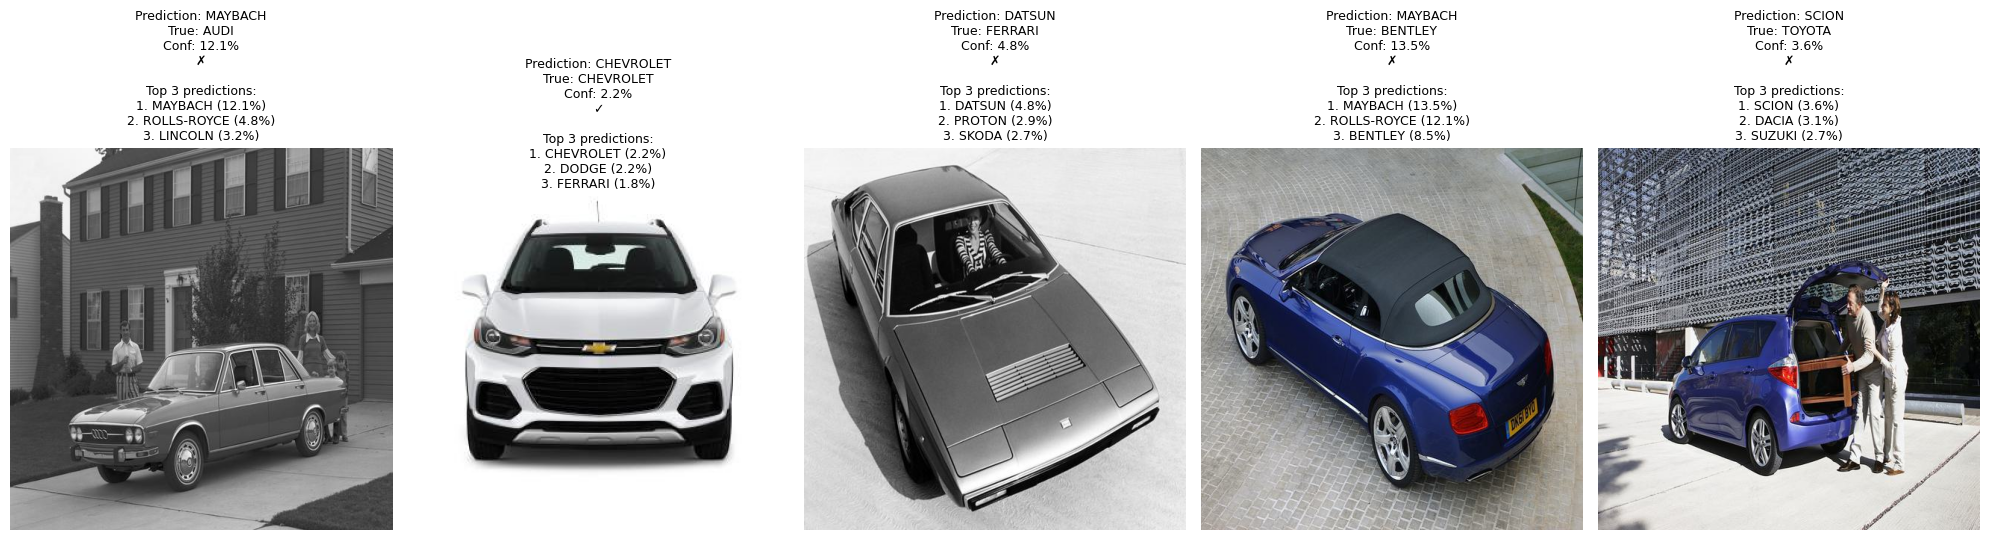


Accuracy on sample: 1/5 (20.0%)
Model device: privateuseone:0
Found 270527 images in test directory
Model has 95 output classes
Final layer output size: 95


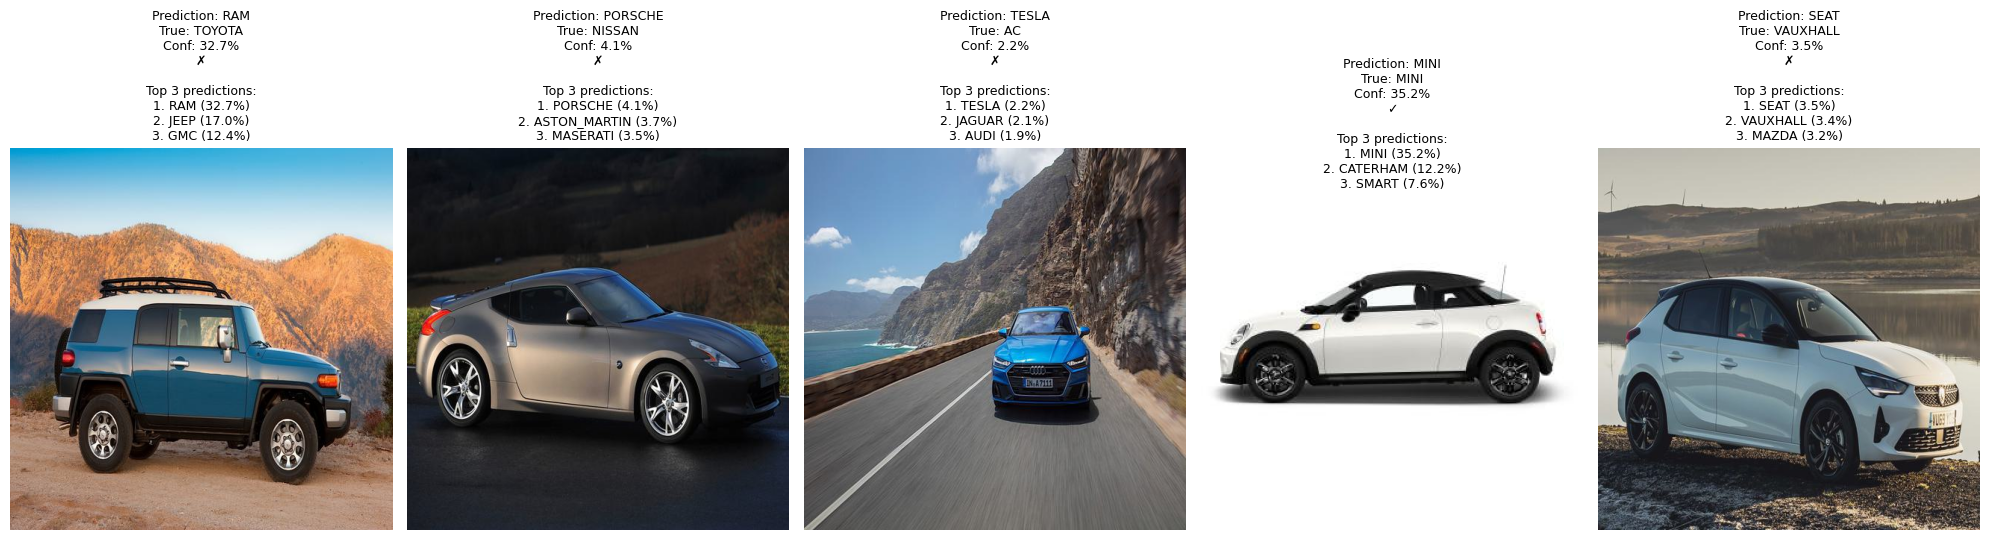


Accuracy on sample: 1/5 (20.0%)


[{'file': 'TOYOTA-FJ-Cruiser-5011_41_TOYOTA_FJ_Cruiser_20112016_train.jpg',
  'true': 'TOYOTA',
  'pred': 'RAM',
  'confidence': 32.66808092594147,
  'correct': False},
 {'file': 'NISSAN-370Z-3760_89_NISSAN_370Z_20082012_train.jpeg',
  'true': 'NISSAN',
  'pred': 'PORSCHE',
  'confidence': 4.085196554660797,
  'correct': False},
 {'file': 'AUDI-A7-Sportback-6152_47_AUDI_A7_Sportback_2017Present_train.jpg',
  'true': 'AC',
  'pred': 'TESLA',
  'confidence': 2.2002961486577988,
  'correct': False},
 {'file': 'MINI_Cooper_2015_25_16_120_16_4_66_55_146_27_FWD_4_2_Convertible_fFb.jpg',
  'true': 'MINI',
  'pred': 'MINI',
  'confidence': 35.152867436409,
  'correct': True},
 {'file': 'VAUXHALL-Corsa-5-Doors-6607_35_VAUXHALL_Corsa_5_Doors_2019Present_train.jpg',
  'true': 'VAUXHALL',
  'pred': 'SEAT',
  'confidence': 3.5026535391807556,
  'correct': False}]

In [ ]:
# Testing the new model

def test_model_with_images(model, class_names, device, test_dir, num_images=5, brand_list=None):
    """Test the retrained model with some random images with enhanced error checking"""
    # Set up transforms - keeping your original transform
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Verify model is in eval mode
    model.eval()
    print(f"Model device: {next(model.parameters()).device}")
    
    # Get random images with better error handling
    try:
        image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not image_files:
            print(f"No image files found in {test_dir}")
            return
            
        # Print some diagnostics
        print(f"Found {len(image_files)} images in test directory")
        print(f"Model has {len(class_names)} output classes")
        print(f"Final layer output size: {list(model.modules())[-1].out_features}")
        
        # Sample images
        sample_images = random.sample(image_files, min(num_images, len(image_files)))
        
    except Exception as e:
        print(f"Error accessing test directory: {e}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 5))
    if len(sample_images) == 1:
        axes = [axes]
    
    # Track results
    results = []
    
    # Process each image
    for i, img_file in enumerate(sample_images):
        try:
            img_path = os.path.join(test_dir, img_file)
            
            # Load and preprocess image
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)
            
            # Try to determine true brand from filename
            true_brand = "Unknown"
            # Use brand_list if provided, otherwise try to use all_brands global variable
            brand_reference = brand_list if brand_list is not None else all_brands
            
            for brand in brand_reference:
                if brand.lower() in img_file.lower():
                    true_brand = brand
                    break
            
            # Get prediction with error handling
            with torch.no_grad():
                outputs = model(img_tensor)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                
                # Get top 3 predictions
                values, indices = torch.topk(probs, 3)
                top_preds = [(class_names[idx.item()], val.item() * 100) for idx, val in zip(indices, values)]
                
                confidence, pred_idx = torch.max(probs, 0)
                pred_brand = class_names[pred_idx.item()]
                conf_value = confidence.item() * 100
            
            # Display image with prediction
            axes[i].imshow(image)
            axes[i].axis('off')
            match = "✓" if pred_brand.replace('_', ' ').lower() == true_brand.lower() else "✗"
            
            title = f"Prediction: {pred_brand}\nTrue: {true_brand}\nConf: {conf_value:.1f}%\n{match}"
            # Add top 3 preds to title
            title += "\n\nTop 3 predictions:"
            for j, (name, score) in enumerate(top_preds):
                title += f"\n{j+1}. {name} ({score:.1f}%)"
                
            axes[i].set_title(title, fontsize=9)
            
            # Save result
            results.append({
                'file': img_file,
                'true': true_brand,
                'pred': pred_brand,
                'confidence': conf_value,
                'correct': pred_brand.replace('_', ' ').lower() == true_brand.lower()
            })
            
        except Exception as e:
            print(f"Error processing image {img_file}: {e}")
            if i < len(axes):
                axes[i].text(0.5, 0.5, f"Error: {str(e)}", 
                            ha='center', va='center', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    correct = sum(1 for r in results if r['correct'])
    print(f"\nAccuracy on sample: {correct}/{len(results)} ({correct/len(results)*100:.1f}%)")
    return results

# First, recreate the model architecture
model = models.resnet50(weights='IMAGENET1K_V2')

# Check if model file exists
if not os.path.exists('retrained_model.pth'):
    print("Error: retrained_model.pth not found!")
else:
    # Recreate the architecture with the exact same structure
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512), 
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(class_names))
    )
    
    try:
        # Load model weights
        model.load_state_dict(torch.load('retrained_model.pth'))
        print("Successfully loaded model weights")
        
        # Move model to device
        model = model.to(device)
        
        # Test the model
        test_results = test_model_with_images(
            model=model,
            class_names=class_names,
            device=device,
            test_dir='./images/cars5',
            num_images=5,
            brand_list=all_brands  # Pass explicitly to avoid dependency on global
        )
    except Exception as e:
        print(f"Error testing model: {e}")

# Test the retrained model
test_model_with_images(
    model=model,  # Pass the model object, not the load_state_dict result
    class_names=class_names,
    device=device,
    test_dir='./images/cars5',
    num_images=5
)

____

### WORK IN PROGRESS TRAINING WITH RANDOMIZED NAMES OF IMAGES

In [ ]:
def organize_random_car_images(source_dir, output_dir, model, transform, class_names, 
                              confidence_threshold=0.7, copy_instead_of_move=True):
    """
    Auto-organize random car images using trained model predictions
    
    Args:
        source_dir: Directory containing random car images (e.g., './images/cars')
        output_dir: Directory to organize images into class folders (e.g., './organized_cars')
        model: Trained car classification model
        transform: Image transformation pipeline
        class_names: List of class names (car makes)
        confidence_threshold: Minimum confidence to assign a class
        copy_instead_of_move: If True, copy images; if False, move them
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create class directories
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
    
    # Get all images from source directory
    image_files = [f for f in os.listdir(source_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Found {len(image_files)} images in {source_dir}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Track results
    results = {
        'processed': 0,
        'organized': 0,
        'low_confidence': 0,
        'errors': 0,
        'class_distribution': {}
    }
    
    # Process each image
    for img_file in tqdm(image_files, desc="Classifying car images"):
        try:
            img_path = os.path.join(source_dir, img_file)
            results['processed'] += 1
            
            # Load and preprocess the image
            image = Image.open(img_path).convert('RGB')
            img_tensor = transform(image).unsqueeze(0).to(device)
            
            # Get model prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                conf_val, pred_idx = torch.max(probs, 0)
                
                confidence = conf_val.item()
                pred_class = class_names[pred_idx.item()]
                
            # If confidence meets threshold, organize the image
            if confidence >= confidence_threshold:
                # Update class distribution counter
                results['class_distribution'][pred_class] = \
                    results['class_distribution'].get(pred_class, 0) + 1
                
                # Destination path
                dst_path = os.path.join(output_dir, pred_class, img_file)
                
                # Copy or move the file
                if copy_instead_of_move:
                    shutil.copy2(img_path, dst_path)  # copy2 preserves metadata
                else:
                    shutil.move(img_path, dst_path)
                
                results['organized'] += 1
            else:
                results['low_confidence'] += 1
                
        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            results['errors'] += 1
    
    # Print results
    print("\nClassification Results:")
    print(f"Total images processed: {results['processed']}")
    print(f"Images organized: {results['organized']} ({results['organized']/results['processed']*100:.1f}%)")
    print(f"Low confidence images: {results['low_confidence']} ({results['low_confidence']/results['processed']*100:.1f}%)")
    print(f"Errors: {results['errors']} ({results['errors']/results['processed']*100:.1f}%)")
    
    # Print class distribution
    print("\nClass Distribution:")
    for class_name, count in sorted(results['class_distribution'].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{class_name}: {count} images")
    
    return results, output_dir

In [ ]:
# Use your best model
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))
model.eval()

# Organize random car images
results, organized_dir = organize_random_car_images(
    source_dir='./images/cars',           # Your single folder with random car images
    output_dir='./organized_cars',        # Where to place organized images
    model=model,
    transform=data_transforms['test'],    # Use your test transforms
    class_names=class_names,
    confidence_threshold=0.6,             # Adjust based on model performance
    copy_instead_of_move=True             # Keep originals
)

In [ ]:
# Create datasets from organized images
new_datasets = create_image_datasets('./organized_cars', data_transforms)

# Update your dataloaders
new_dataloaders = {
    'train': DataLoader(new_datasets['train'], batch_size=16, shuffle=True, num_workers=4),
    'valid': DataLoader(new_datasets['valid'], batch_size=16, shuffle=False, num_workers=4) if new_datasets['valid'] is not None else None,
    'test': DataLoader(new_datasets['test'], batch_size=16, shuffle=False, num_workers=4) if new_datasets['test'] is not None else None,
}

# Use a lower learning rate for fine-tuning
learning_rate = 0.001  # 10x smaller than initial rate

# Update global variables
dataloaders = new_dataloaders
class_names = new_datasets['train'].classes
num_classes = len(class_names)

# Fine-tune model
train_with_progressive_unfreezing(num_epochs=20, accumulation_steps=2)